In [1]:
# !pip install numpy
# !pip install matplotlib
# !pip install tensorflow


In [18]:
import sys
print(sys.executable)
print(sys.version)

/usr/bin/python3
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import shutil
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input as preprocess_input_mobilenet
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input as preprocess_input_nasnet


2023-12-06 19:46:48.364493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
gpu_device = tf.test.gpu_device_name()
if gpu_device:
  print(f'GPU found: {gpu_device}')
else:
  print(f'No GPU found, using CPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPU found: /device:GPU:0
Num GPUs Available:  7


2023-12-03 21:28:31.796630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 9647 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2023-12-03 21:28:31.798189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:1 with 9647 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2023-12-03 21:28:31.799530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:2 with 9647 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:87:00.0, compute capability: 7.5
2023-12-03 21:28:31.800782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:3 with 7391 MB memory:  -> device: 3, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-12-03 21:28:31.801986: I tensorflow/core/common_runtime/gpu/gp

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
model_save_path = 'Final/Final_Project'
history_save_path = 'Final/History'

In [3]:
!git clone https://github.com/ruistond/Deep_Learn.git
#data directory containing train images
data_directory = 'Deep_Learn/Train/'


fatal: destination path 'Deep_Learn' already exists and is not an empty directory.


In [16]:
    filtered_char_dir = 'Final/FilteredChars' # update directory with appropriate path, One time to copy the  filtered char to the directory
#FilteredChars2(aemnst), FilteredChars - (ijz)

In [4]:
split_ratios = [0.25, 0.75]
included_characters1 = ['A', 'E', 'M', 'N', 'S', 'T']
included_characters2 = ['I', 'J', 'Z']
data_generators = {}


In [22]:
# Filter Images - Function

def filter_char(directory, included_chars):
  filtered_dirs = []

  for char in os.listdir(directory):
    if char in included_chars:
      filtered_dirs.append(os.path.join(directory, char))

  return filtered_dirs


In [23]:
# Copy Filtered Images To GDrive / cluster- Function

def copy_images(original_dir, filtered_dir, included_chars):

  for char in included_chars:
    original_char_path = os.path.join(original_dir, char)
    filtered_char_path = os.path.join(filtered_dir, char)

    if not os.path.exists(original_char_path):
      print(f'Directory for {char} does not exist in the image set. Skipping {char}.')
      continue

    if os.path.exists(filtered_char_path):
      print(f'Directory for {char} already exists in filtered directory. Skipping {char}.')
      continue

    shutil.copytree(original_char_path, filtered_char_path)
    print(f'Copied dir for {char}')


In [18]:
# Filter/Copy Images . Done twice if need to run for both datasets

filtered_data_directory = filter_char(data_directory, included_characters1) #update the included_character1 (aemnst) to ...character2 (ijz)

copy_images(data_directory, filtered_char_dir, included_characters1)


Copied dir for A
Copied dir for E
Copied dir for M
Copied dir for N
Copied dir for S
Copied dir for T


In [5]:
# Define models

def create_model(base_model, num_classes):
  base_model.trainable = False
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation= 'relu')(x)
  predictions = Dense(num_classes, activation= 'softmax')(x)
  model = Model(inputs= base_model.input, outputs= predictions)
  return model


In [17]:
# Generators for (244, 244) input size

for split_ratio in split_ratios:
  print(f"Training with {100 * (1 - split_ratio)}% training data")

  train_datagen = ImageDataGenerator(
      rescale = 1./255,
      validation_split = split_ratio,
      horizontal_flip = True,
      zoom_range = 0.2
  )

  train_generator244 = train_datagen.flow_from_directory(
      filtered_char_dir,
      target_size = (224, 224),
      batch_size = 32,
      class_mode = 'categorical',
      subset = 'training'
  )

  validation_generator244 = train_datagen.flow_from_directory(
      filtered_char_dir,
      target_size = (224, 224),
      batch_size = 32,
      class_mode = 'categorical',
      subset = 'validation'
  )

  data_generators[split_ratio] = (train_generator244, validation_generator244)
# below output will print 3 or 6 classes , depending on which path you choose. rerun the current cell till the end if need the same informato

Training with 75.0% training data
Found 6750 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Training with 25.0% training data
Found 2250 images belonging to 3 classes.
Found 6750 images belonging to 3 classes.


In [10]:

#save model to the path set . The files will overwrite if not saved before next iteration
def save_model(model, model_name, split_ratio, path):
  model_filename = f'{model_name}_{int(100 * (1 - split_ratio))}_trainsplit.h5'

  model_save = os.path.join(path, model_filename)

  model.save(model_save)

  print(f'Model saved as {model_filename}')


In [11]:
# Save Model History - Function.The files will overwrite if not saved before next iteration

def save_history(history, model_name, split_ratio):

  history_filename = f'{model_name}_history_{int(100 * (1 - split_ratio))}_trainsplit.json'

  history_save_path_funct = os.path.join(history_save_path, history_filename)

  history_dict = history.history

  with open(history_save_path_funct, 'w') as file:
    json.dump(history_dict, file)

  print(f'History saved as {history_filename}')


In [12]:
# Baseline model - Train Function
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


def train_baseline(model, train_generator, validation_generator, epochs = 2):
  history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // train_generator.batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // validation_generator.batch_size,
      epochs = epochs
  )

  return history


# Baseline model 

In [13]:
# Baseline model - Load/Compile/Train (aemnst)

for split_ratio, (train_generator, validation_generator) in data_generators.items():
  print(f'Training with {100 * (1 - split_ratio)}% training data')

  num_classes = train_generator.num_classes

  baseline_model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
      #layers.MaxPooling2D((2, 2)),
      #layers.Conv2D(64, (3, 3), activation = 'relu'),
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(1024, activation= 'relu'),
      layers.Dense(num_classes, activation = 'softmax')
  ])

  baseline_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

  history_baseline = train_baseline(baseline_model, train_generator, validation_generator, epochs = 5)

  save_model(baseline_model, 'baseline', split_ratio, model_save_path)

  save_history(history_baseline, 'baseline', split_ratio)



Training with 75.0% training data
Epoch 1/5


2023-12-06 19:53:30.960931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-06 19:53:31.166598: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-06 19:53:31.423063: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f500c04f3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 19:53:31.423104: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-06 19:53:31.423115: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-06 19:53:31.423123: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-06 19:53:31.423130: I tensorflow/compiler/xla/service/service.cc:1

421/421 [==============================] - 450s 1s/step - loss: 1.7879 - accuracy: 0.1808 - val_loss: 1.7758 - val_accuracy: 0.1701
Epoch 2/5
421/421 [==============================] - 269s 639ms/step - loss: 1.7423 - accuracy: 0.2277 - val_loss: 1.6840 - val_accuracy: 0.2991
Epoch 3/5
421/421 [==============================] - 268s 638ms/step - loss: 1.6998 - accuracy: 0.2411 - val_loss: 1.5943 - val_accuracy: 0.3100
Epoch 4/5
421/421 [==============================] - 268s 637ms/step - loss: 1.6549 - accuracy: 0.2653 - val_loss: 1.5882 - val_accuracy: 0.2594
Epoch 5/5
421/421 [==============================] - 273s 648ms/step - loss: 1.6029 - accuracy: 0.2917 - val_loss: 1.5366 - val_accuracy: 0.2612


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as baseline_75_trainsplit.h5
History saved as baseline_history_75_trainsplit.json
Training with 25.0% training data
Epoch 1/5
140/140 [==============================] - 271s 2s/step - loss: 1.7847 - accuracy: 0.1787 - val_loss: 1.7826 - val_accuracy: 0.2310
Epoch 2/5
140/140 [==============================] - 272s 2s/step - loss: 1.6904 - accuracy: 0.2680 - val_loss: 1.8065 - val_accuracy: 0.2027
Epoch 3/5
140/140 [==============================] - 274s 2s/step - loss: 1.5128 - accuracy: 0.3391 - val_loss: 1.9843 - val_accuracy: 0.2633
Epoch 4/5
140/140 [==============================] - 267s 2s/step - loss: 1.3698 - accuracy: 0.4101 - val_loss: 2.1374 - val_accuracy: 0.2474
Epoch 5/5
140/140 [==============================] - 274s 2s/step - loss: 1.2632 - accuracy: 0.4787 - val_loss: 2.2553 - val_accuracy: 0.1991
Model saved as baseline_25_trainsplit.h5
History saved as baseline_history_25_trainsplit.json


In [19]:
# Baseline model - Load/Compile/Train (ijz)

for split_ratio, (train_generator, validation_generator) in data_generators.items():
  print(f'Training with {100 * (1 - split_ratio)}% training data')

  num_classes = train_generator.num_classes

  baseline_model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (224, 224, 3)),
      #layers.MaxPooling2D((2, 2)),
      #layers.Conv2D(64, (3, 3), activation = 'relu'),
      layers.GlobalAveragePooling2D(),
      layers.Flatten(),
      layers.Dense(1024, activation= 'relu'),
      layers.Dense(num_classes, activation = 'softmax')
  ])

  baseline_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

  history_baseline = train_baseline(baseline_model, train_generator, validation_generator, epochs = 5)

  save_model(baseline_model, 'baseline1', split_ratio, model_save_path)

  save_history(history_baseline, 'baseline1', split_ratio)



Training with 75.0% training data
Epoch 1/5
210/210 [==============================] - 208s 949ms/step - loss: 1.0993 - accuracy: 0.3433 - val_loss: 1.0941 - val_accuracy: 0.3906
Epoch 2/5
210/210 [==============================] - 134s 636ms/step - loss: 1.0916 - accuracy: 0.3741 - val_loss: 1.0618 - val_accuracy: 0.4344
Epoch 3/5
210/210 [==============================] - 136s 648ms/step - loss: 1.0727 - accuracy: 0.4067 - val_loss: 0.9908 - val_accuracy: 0.4906
Epoch 4/5
210/210 [==============================] - 136s 647ms/step - loss: 1.0536 - accuracy: 0.4427 - val_loss: 0.9315 - val_accuracy: 0.5246
Epoch 5/5
210/210 [==============================] - 134s 640ms/step - loss: 1.0386 - accuracy: 0.4522 - val_loss: 0.9115 - val_accuracy: 0.5830
Model saved as baseline1_75_trainsplit.h5
History saved as baseline1_history_75_trainsplit.json
Training with 25.0% training data
Epoch 1/5
70/70 [==============================] - 134s 2s/step - loss: 1.0997 - accuracy: 0.3300 - val_loss: 1

**ResNet50 Model**

In [23]:
# ResNet50 model - Train Function

def train_resnet(model, train_generator, validation_generator, epochs = 2):
  history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // train_generator.batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // validation_generator.batch_size,
      epochs = epochs
  )

  return history


In [24]:
# Create the directory if it doesn't exist
os.makedirs(history_save_path, exist_ok=True)


In [25]:
# ResNet50 model - Load/Compile/Train

for split_ratio, (train_generator, validation_generator) in data_generators.items():
  print(f'Training with {100 * (1 - split_ratio)}% training data')

  resnet_model = create_model(ResNet50(input_shape= (224, 224, 3), weights= 'imagenet', include_top= False),
                              train_generator.num_classes)

  resnet_model.compile(optimizer= Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

  history_resnet = train_resnet(resnet_model, train_generator, validation_generator, epochs = 5)

  save_model(resnet_model, 'resnet50', split_ratio, model_save_path)

  save_history(history_resnet, 'resnet50', split_ratio)


Training with 75.0% training data


2023-12-02 14:26:45.501788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9647 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5
2023-12-02 14:26:45.502555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9647 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2023-12-02 14:26:45.503309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9647 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:87:00.0, compute capability: 7.5
2023-12-02 14:26:45.504065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 7391 MB memory:  -> device: 3, name: NVIDIA GeForce GTX

Epoch 1/5


2023-12-02 14:26:54.379710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-02 14:26:54.563873: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-02 14:26:55.631331: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c57f40f670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-02 14:26:55.631386: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-02 14:26:55.631400: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-02 14:26:55.631410: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-12-02 14:26:55.631421: I tensorflow/compiler/xla/service/service.cc:1

421/421 [==============================] - 651s 2s/step - loss: 1.7994 - accuracy: 0.2282 - val_loss: 1.7604 - val_accuracy: 0.1703
Epoch 2/5
421/421 [==============================] - 271s 643ms/step - loss: 1.6669 - accuracy: 0.2950 - val_loss: 1.8237 - val_accuracy: 0.1781
Epoch 3/5
421/421 [==============================] - 273s 649ms/step - loss: 1.6000 - accuracy: 0.3326 - val_loss: 1.6442 - val_accuracy: 0.2710
Epoch 4/5
421/421 [==============================] - 270s 641ms/step - loss: 1.5183 - accuracy: 0.3718 - val_loss: 1.6166 - val_accuracy: 0.2962
Epoch 5/5
421/421 [==============================] - 269s 640ms/step - loss: 1.4800 - accuracy: 0.3946 - val_loss: 1.6334 - val_accuracy: 0.2574


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as resnet50_75_trainsplit.h5
History saved as resnet50_history_75_trainsplit.json
Training with 25.0% training data
Epoch 1/5
140/140 [==============================] - 276s 2s/step - loss: 1.6778 - accuracy: 0.3107 - val_loss: 1.9997 - val_accuracy: 0.2084
Epoch 2/5
140/140 [==============================] - 274s 2s/step - loss: 1.4087 - accuracy: 0.4087 - val_loss: 2.2927 - val_accuracy: 0.1784
Epoch 3/5
140/140 [==============================] - 269s 2s/step - loss: 1.2554 - accuracy: 0.4758 - val_loss: 2.2406 - val_accuracy: 0.1849
Epoch 4/5
140/140 [==============================] - 278s 2s/step - loss: 1.1385 - accuracy: 0.5289 - val_loss: 2.3433 - val_accuracy: 0.1779
Epoch 5/5
140/140 [==============================] - 273s 2s/step - loss: 1.0468 - accuracy: 0.5692 - val_loss: 2.7449 - val_accuracy: 0.1935
Model saved as resnet50_25_trainsplit.h5
History saved as resnet50_history_25_trainsplit.json


**VGG16 Model**

In [26]:
# VGG16 model - Train

def train_vgg(model, train_generator, validation_generator, epochs = 2):
  history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // train_generator.batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // validation_generator.batch_size,
      epochs = epochs
  )
  return history


In [27]:
# VGG16 model - Load/Compile/Train

for split_ratio, (train_generator, validation_generator) in data_generators.items():
  print(f'Training with {100 * (1 - split_ratio)}% training data')

  vgg_model = create_model(VGG16(input_shape = (224, 224, 3), weights= 'imagenet', include_top= False),
                          train_generator.num_classes)

  vgg_model.compile(optimizer= Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

  history_vgg = train_vgg(vgg_model, train_generator, validation_generator, epochs = 5)

  save_model(vgg_model, 'vgg16', split_ratio, model_save_path)

  save_history(history_vgg, 'vgg16', split_ratio)


Training with 75.0% training data
Epoch 1/5
421/421 [==============================] - 273s 641ms/step - loss: 0.8659 - accuracy: 0.7133 - val_loss: 0.6710 - val_accuracy: 0.7576
Epoch 2/5
421/421 [==============================] - 269s 640ms/step - loss: 0.3085 - accuracy: 0.9076 - val_loss: 0.5721 - val_accuracy: 0.7728
Epoch 3/5
421/421 [==============================] - 269s 638ms/step - loss: 0.2091 - accuracy: 0.9325 - val_loss: 0.5836 - val_accuracy: 0.7891
Epoch 4/5
421/421 [==============================] - 270s 643ms/step - loss: 0.1589 - accuracy: 0.9484 - val_loss: 0.5676 - val_accuracy: 0.7913
Epoch 5/5
421/421 [==============================] - 272s 646ms/step - loss: 0.1397 - accuracy: 0.9510 - val_loss: 0.5991 - val_accuracy: 0.7893
Model saved as vgg16_75_trainsplit.h5
History saved as vgg16_history_75_trainsplit.json
Training with 25.0% training data
Epoch 1/5
140/140 [==============================] - 271s 2s/step - loss: 0.9007 - accuracy: 0.7325 - val_loss: 1.4651 

**MobileNet Model**

In [28]:
# MobileNet model - Train

def train_mobilenet(model, train_generator, validation_generator, epochs = 2):
  history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // train_generator.batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // validation_generator.batch_size,
      epochs = epochs
  )

  return history


In [29]:
# MobileNet model - Load/Compile/Train

for split_ratio, (train_generator, validation_generator) in data_generators.items():
  print(f'Training with {100 * (1 - split_ratio)}% training data')

  mobilenet_model = create_model(MobileNet(input_shape= (224, 224, 3), weights= 'imagenet', include_top= False),
                                train_generator244.num_classes)

  mobilenet_model.compile(optimizer= Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

  history_mobilenet = train_mobilenet(mobilenet_model, train_generator, validation_generator, epochs = 5)

  save_model(mobilenet_model, 'mobilenet', split_ratio, model_save_path)

  save_history(history_mobilenet, 'mobilenet', split_ratio)


Training with 75.0% training data
Epoch 1/5
421/421 [==============================] - 274s 643ms/step - loss: 0.1523 - accuracy: 0.9549 - val_loss: 0.2787 - val_accuracy: 0.8962
Epoch 2/5
421/421 [==============================] - 269s 640ms/step - loss: 0.0243 - accuracy: 0.9918 - val_loss: 0.3079 - val_accuracy: 0.9105
Epoch 3/5
421/421 [==============================] - 270s 642ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.2974 - val_accuracy: 0.9065
Epoch 4/5
421/421 [==============================] - 275s 654ms/step - loss: 0.0234 - accuracy: 0.9918 - val_loss: 0.8071 - val_accuracy: 0.8156
Epoch 5/5
421/421 [==============================] - 275s 653ms/step - loss: 0.0236 - accuracy: 0.9917 - val_loss: 0.3769 - val_accuracy: 0.9045
Model saved as mobilenet_75_trainsplit.h5
History saved as mobilenet_history_75_trainsplit.json
Training with 25.0% training data
Epoch 1/5
140/140 [==============================] - 272s 2s/step - loss: 0.1656 - accuracy: 0.9588 - val_loss:

**NASNet Model**

In [30]:
# NASNet model - Train

def train_nasnet(model, train_generator, validation_generator, epochs = 5):
  history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // train_generator.batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // validation_generator.batch_size,
      epochs = epochs
  )

  return history


In [31]:
# NASNet model - Load/Compile/Train

for split_ratio, (train_generator, validation_generator) in data_generators.items():
  print(f'Training with {100 * (1 - split_ratio)}% training data')

  nasnet_model = create_model(NASNetMobile(input_shape= (224, 224, 3), weights= 'imagenet', include_top= False),
                                train_generator244.num_classes)

  nasnet_model.compile(optimizer= Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

  history_nasnet = train_nasnet(nasnet_model, train_generator, validation_generator, epochs = 5)

  save_model(nasnet_model, 'nasnet', split_ratio, model_save_path)

  save_history(history_nasnet, 'nasnet', split_ratio)


Training with 75.0% training data
Epoch 1/5
421/421 [==============================] - 294s 654ms/step - loss: 0.3675 - accuracy: 0.8676 - val_loss: 0.9711 - val_accuracy: 0.6996
Epoch 2/5
421/421 [==============================] - 272s 647ms/step - loss: 0.1404 - accuracy: 0.9477 - val_loss: 0.8133 - val_accuracy: 0.7507
Epoch 3/5
421/421 [==============================] - 275s 652ms/step - loss: 0.1046 - accuracy: 0.9618 - val_loss: 0.7568 - val_accuracy: 0.7728
Epoch 4/5
421/421 [==============================] - 270s 642ms/step - loss: 0.0904 - accuracy: 0.9681 - val_loss: 0.7448 - val_accuracy: 0.7781
Epoch 5/5
421/421 [==============================] - 270s 642ms/step - loss: 0.0751 - accuracy: 0.9733 - val_loss: 0.6821 - val_accuracy: 0.7893
Model saved as nasnet_75_trainsplit.h5
History saved as nasnet_history_75_trainsplit.json
Training with 25.0% training data
Epoch 1/5
140/140 [==============================] - 295s 2s/step - loss: 0.2226 - accuracy: 0.9270 - val_loss: 2.353

**Load Pre-Saved Models**

In [15]:
baseline_model25 = load_model('Final/Final_Project/baseline_25_trainsplit.h5')
baseline_model75 = load_model('Final/Final_Project/baseline_75_trainsplit.h5')


In [32]:
# To Load Pre-Saved Models/History
resnet_model25 = load_model('Final/Final_Project/resnet50_25_trainsplit.h5')
resnet_model75 = load_model('Final/Final_Project/resnet50_75_trainsplit.h5')

baseline_model25 = load_model('Final/Final_Project/baseline_25_trainsplit.h5')
baseline_model75 = load_model('Final/Final_Project/baseline_75_trainsplit.h5')

vgg_model25 = load_model('Final/Final_Project/vgg16_25_trainsplit.h5')
vgg_model75 = load_model('Final/Final_Project/vgg16_75_trainsplit.h5')

mobilenet_model25 = load_model('Final/Final_Project/mobilenet_25_trainsplit.h5')
mobilenet_model75 = load_model('Final/Final_Project/mobilenet_75_trainsplit.h5')

nasnet_model25 = load_model('Final/Final_Project/nasnet_25_trainsplit.h5')
nasnet_model75 = load_model('Final/Final_Project/nasnet_75_trainsplit.h5')

history_load_path_resnet25 = 'Final/History/resnet50_history_25_trainsplit.json'
history_load_path_resnet75 = 'Final/History/resnet50_history_75_trainsplit.json'

history_load_path_vgg25 = 'Final/History/vgg16_history_25_trainsplit.json'
history_load_path_vgg75 = 'Final/History/vgg16_history_75_trainsplit.json'

history_load_path_mobilenet25 = 'Final/History/mobilenet_history_25_trainsplit.json'
history_load_path_mobilenet75 = 'Final/History/mobilenet_history_75_trainsplit.json'

history_load_path_nasnet25 = 'Final/History/nasnet_history_25_trainsplit.json'
history_load_path_nasnet75 = 'Final/History/nasnet_history_75_trainsplit.json'

def load_history_json(file_path):

  with open(file_path, 'r') as file:
    history = json.load(file)

  print(f'File loaded: {file_path}')

  return history

history_resnet25 = load_history_json(history_load_path_resnet25)
history_resnet75 = load_history_json(history_load_path_resnet75)

history_vgg25 = load_history_json(history_load_path_vgg25)
history_vgg75 = load_history_json(history_load_path_vgg75)

history_mobilenet25 = load_history_json(history_load_path_mobilenet25)
history_mobilenet75 = load_history_json(history_load_path_mobilenet75)

history_nasnet25 = load_history_json(history_load_path_nasnet25)
history_nasnet75 = load_history_json(history_load_path_nasnet75)


File loaded: Final/History/resnet50_history_25_trainsplit.json
File loaded: Final/History/resnet50_history_75_trainsplit.json
File loaded: Final/History/vgg16_history_25_trainsplit.json
File loaded: Final/History/vgg16_history_75_trainsplit.json
File loaded: Final/History/mobilenet_history_25_trainsplit.json
File loaded: Final/History/mobilenet_history_75_trainsplit.json
File loaded: Final/History/nasnet_history_25_trainsplit.json
File loaded: Final/History/nasnet_history_75_trainsplit.json


**Metrics / Comparison**

In [33]:
# Plot Training Histories - Function

def plot_training_history(history, title):
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize= (15, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'b', label= 'Training Accuracy')
  plt.plot(epochs, val_acc, 'r', label= 'Validation Accuracy')
  plt.title(f'Training and Validation Accuracy for {title}')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'b', label= 'Training Loss')
  plt.plot(epochs, val_loss, 'r', label= 'Validation Loss')
  plt.title(f'Training and Validation Loss for {title}')
  plt.legend()

  plt.show()


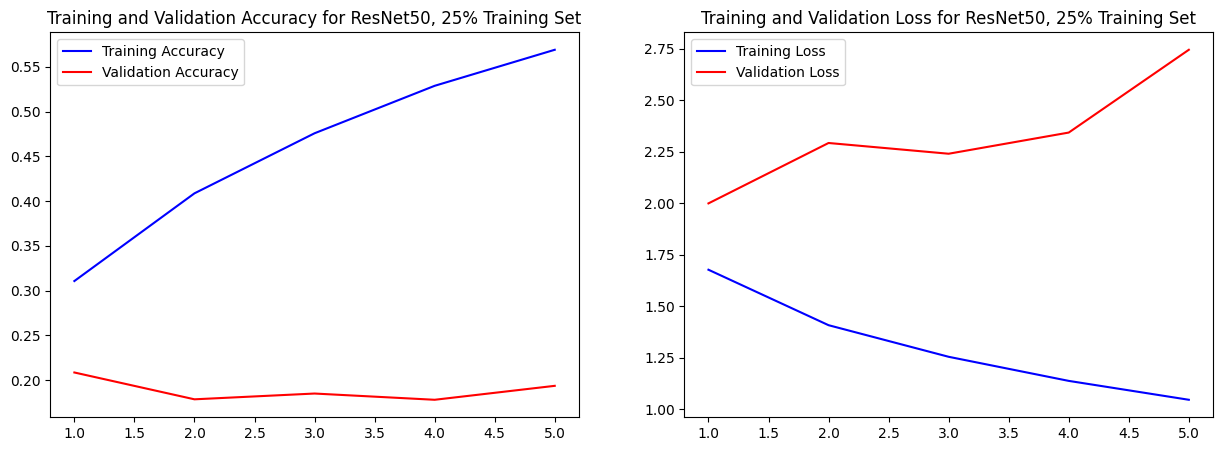

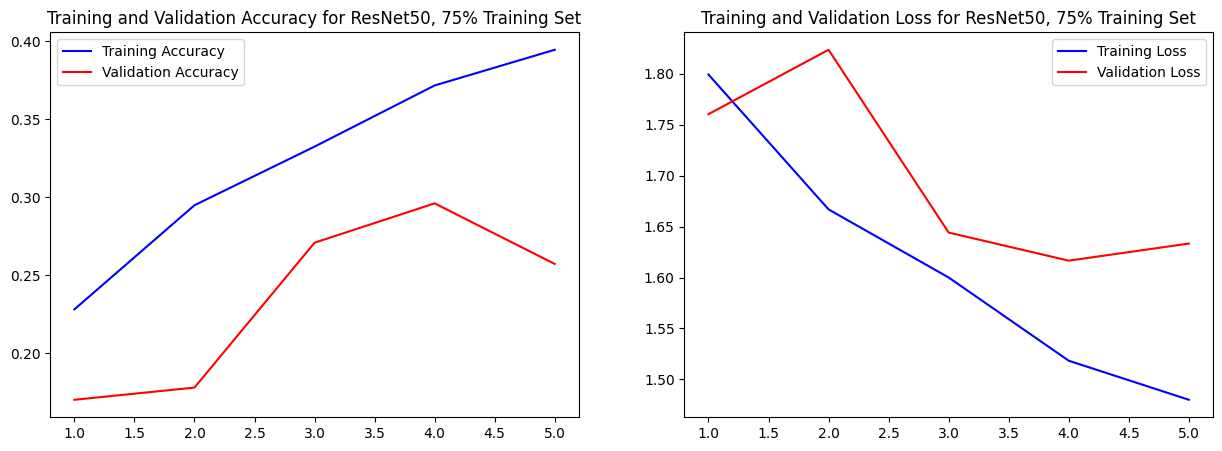

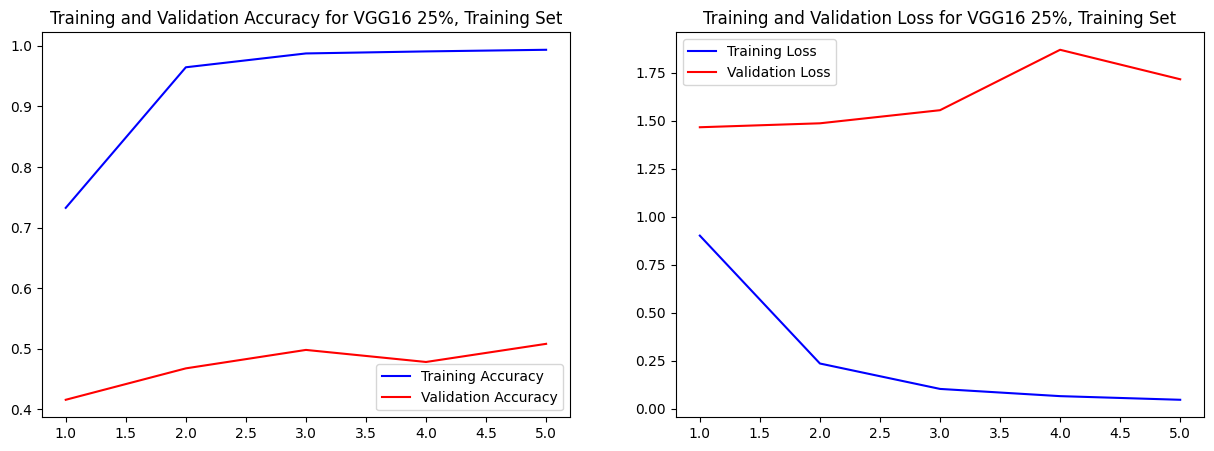

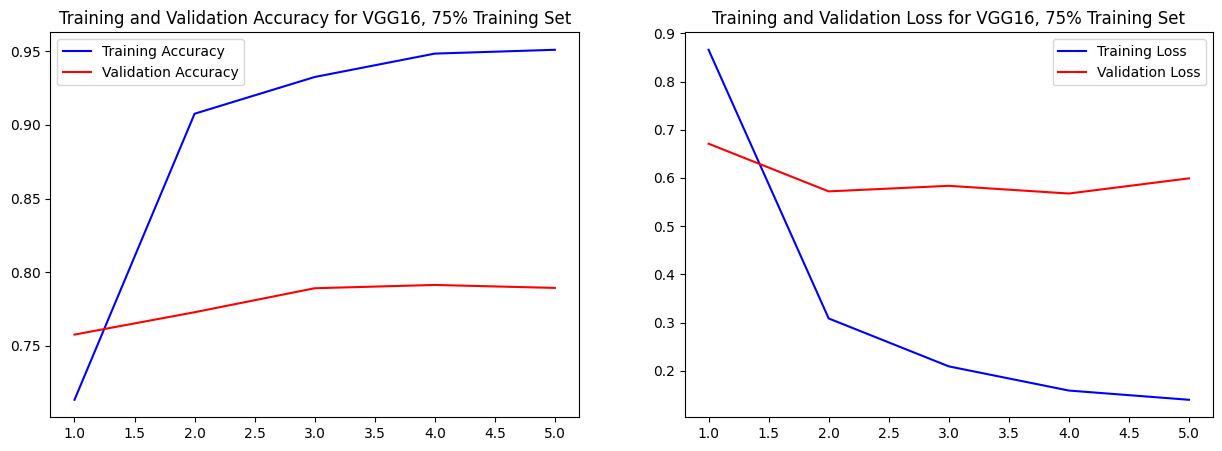

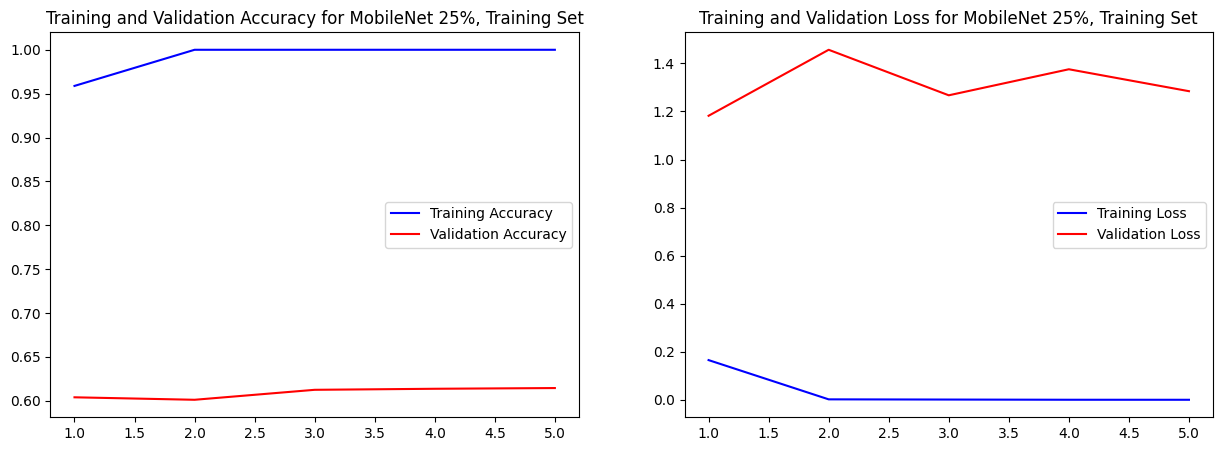

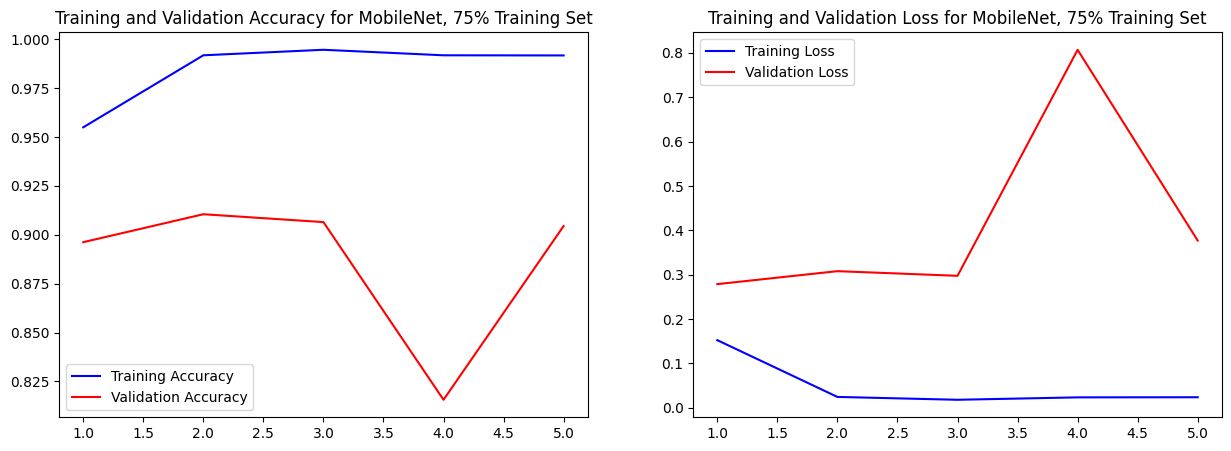

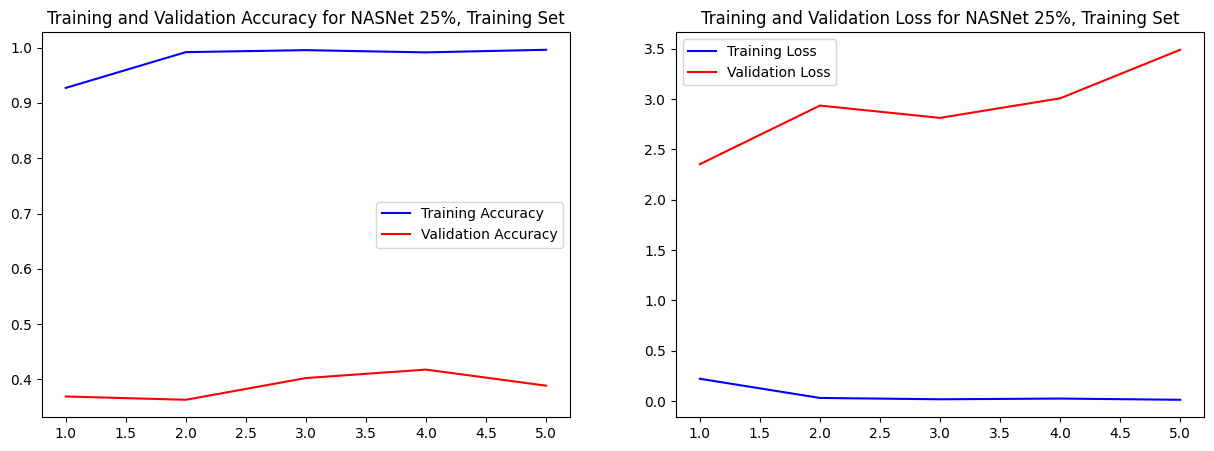

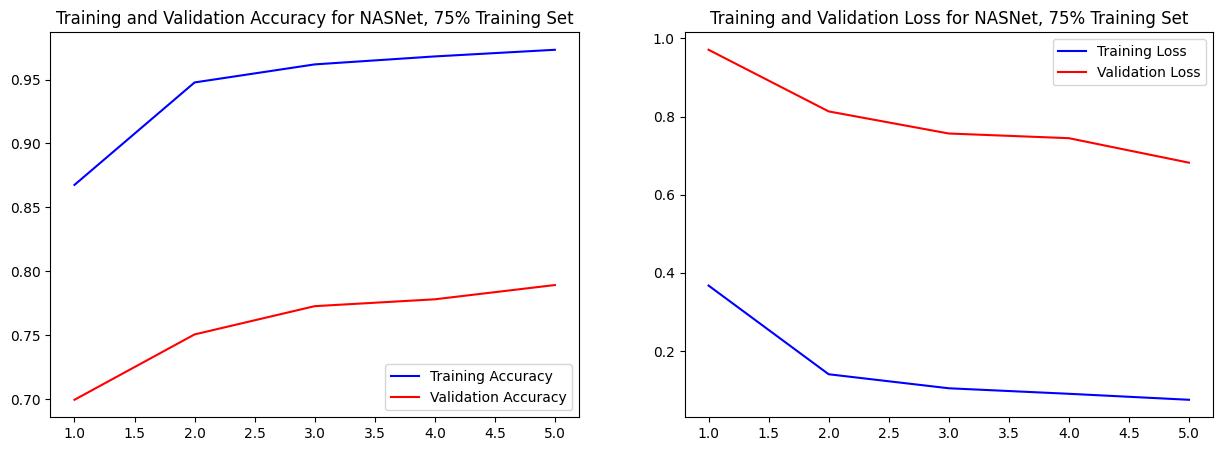

In [34]:
# Plot Training Histories

#Baseline was captured in the previous version of the notebook
plot_training_history(history_resnet25, 'ResNet50, 25% Training Set')
plot_training_history(history_resnet75, 'ResNet50, 75% Training Set')

plot_training_history(history_vgg25, 'VGG16 25%, Training Set')
plot_training_history(history_vgg75, 'VGG16, 75% Training Set')

plot_training_history(history_mobilenet25, 'MobileNet 25%, Training Set')
plot_training_history(history_mobilenet75, 'MobileNet, 75% Training Set')

plot_training_history(history_nasnet25, 'NASNet 25%, Training Set')
plot_training_history(history_nasnet75, 'NASNet, 75% Training Set')


In [35]:
# Compare The Models - Function

def compare_models(histories, titles, train_ratio, metric= 'accuracy'):
  plt.figure(figsize= (8, 5))
  for history, title in zip(histories, titles):
    plt.plot(history[metric], label= f'{title} Train')
    plt.plot(history[f'val_{metric}'], label= f'{title} Val')

  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.title(f'Comparison of Models {metric.capitalize()}, {100 * train_ratio}% Training Set')

  plt.legend()

  plt.show()


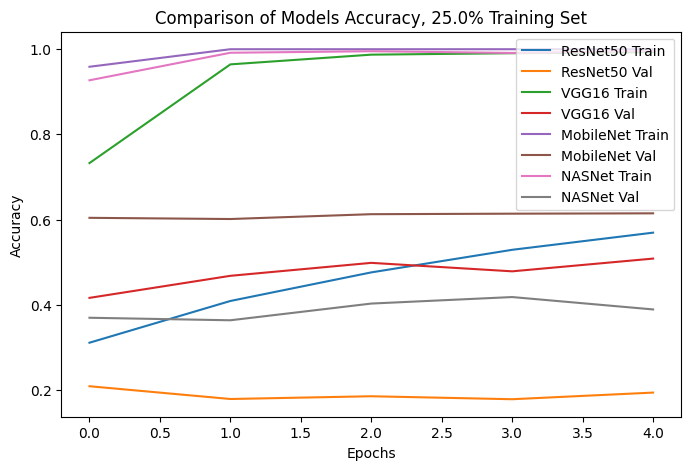

In [36]:
# Compare The Models - 25% Training Set

models_to_compare = [history_resnet25, history_vgg25, history_mobilenet25, history_nasnet25]
titles_to_compare = ['ResNet50', 'VGG16', 'MobileNet', 'NASNet']

compare_models(models_to_compare, titles_to_compare,0.25)


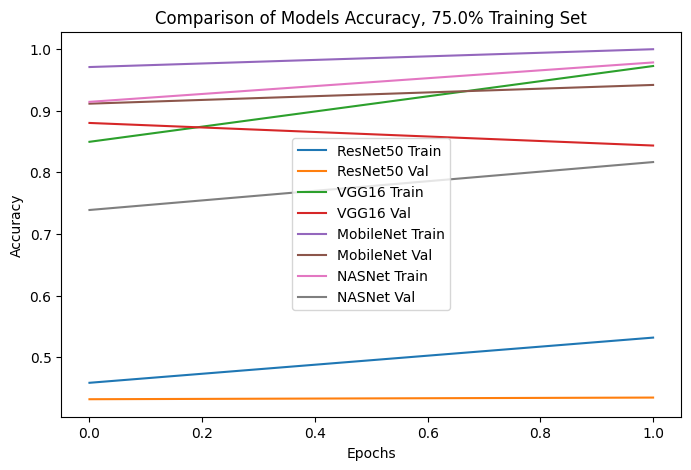

In [86]:
# Compare The Models - 75% Training Set

models_to_compare = [history_resnet75, history_vgg75, history_mobilenet75, history_nasnet75]
titles_to_compare = ['ResNet50', 'VGG16', 'MobileNet', 'NASNet']

compare_models(models_to_compare, titles_to_compare, 0.75)


In [ ]:
# Below is repeated task to capture additional visuals and Baseline

In [ ]:
# To Load Pre-Saved Models/History

resnet_model25 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/resnet50_25_trainsplit.h5')
resnet_model75 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/resnet50_75_trainsplit.h5')

vgg_model25 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/vgg16_25_trainsplit.h5')
vgg_model75 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/vgg16_75_trainsplit.h5')

mobilenet_model25 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/mobilenet_25_trainsplit.h5')
mobilenet_model75 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/mobilenet_75_trainsplit.h5')

nasnet_model25 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/nasnet_25_trainsplit.h5')
nasnet_model75 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/nasnet_75_trainsplit.h5')

baseline_model25 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/baseline_25_trainsplit.h5')
baseline_model75 = load_model('/content/drive/My Drive/H518_DeepLearningNN/Final_Project/baseline_75_trainsplit.h5')

history_load_path_resnet25 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/resnet50_history_25_trainsplit.json'
history_load_path_resnet75 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/resnet50_history_75_trainsplit.json'

history_load_path_vgg25 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/vgg16_history_25_trainsplit.json'
history_load_path_vgg75 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/vgg16_history_75_trainsplit.json'

history_load_path_mobilenet25 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/mobilenet_history_25_trainsplit.json'
history_load_path_mobilenet75 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/mobilenet_history_75_trainsplit.json'

history_load_path_nasnet25 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/nasnet_history_25_trainsplit.json'
history_load_path_nasnet75 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/nasnet_history_75_trainsplit.json'

history_load_path_baseline25 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/baseline_history_25_trainsplit.json'
history_load_path_baseline75 = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/baseline_history_75_trainsplit.json'

def load_history_json(file_path):

  with open(file_path, 'r') as file:
    history = json.load(file)

  print(f'File loaded: {file_path}')

  return history

history_resnet25 = load_history_json(history_load_path_resnet25)
history_resnet75 = load_history_json(history_load_path_resnet75)

history_vgg25 = load_history_json(history_load_path_vgg25)
history_vgg75 = load_history_json(history_load_path_vgg75)

history_mobilenet25 = load_history_json(history_load_path_mobilenet25)
history_mobilenet75 = load_history_json(history_load_path_mobilenet75)

history_nasnet25 = load_history_json(history_load_path_nasnet25)
history_nasnet75 = load_history_json(history_load_path_nasnet75)

history_baseline25 = load_history_json(history_load_path_baseline25)
history_baseline75 = load_history_json(history_load_path_baseline75)


File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/resnet50_history_25_trainsplit.json
File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/resnet50_history_75_trainsplit.json
File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/vgg16_history_25_trainsplit.json
File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/vgg16_history_75_trainsplit.json
File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/mobilenet_history_25_trainsplit.json
File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/mobilenet_history_75_trainsplit.json
File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/nasnet_history_25_trainsplit.json
File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/nasnet_history_75_trainsplit.json
File loaded: /content/drive/My Drive/H518_DeepLearningNN/Final_Project/History/baseline_

In [ ]:
# Plot Training Histories - Function

def plot_training_history(history, title):
  acc = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize= (15, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'b', label= 'Training Accuracy')
  plt.plot(epochs, val_acc, 'r', label= 'Validation Accuracy')
  plt.title(f'Training and Validation Accuracy for {title}')
  plt.legend()
  plt.xticks(epochs)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'b', label= 'Training Loss')
  plt.plot(epochs, val_loss, 'r', label= 'Validation Loss')
  plt.title(f'Training and Validation Loss for {title}')
  plt.legend()
  plt.xticks(epochs)

  plt.show()


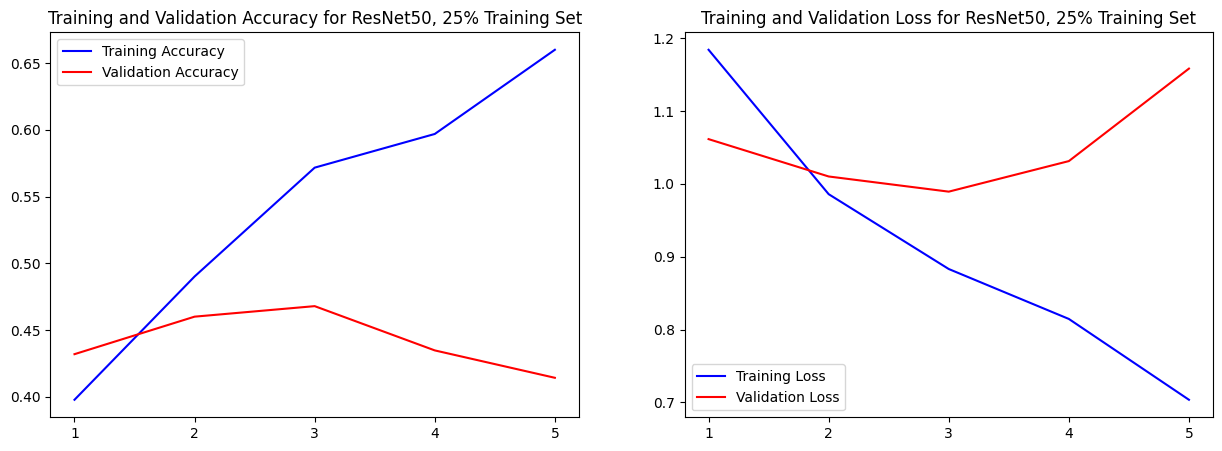

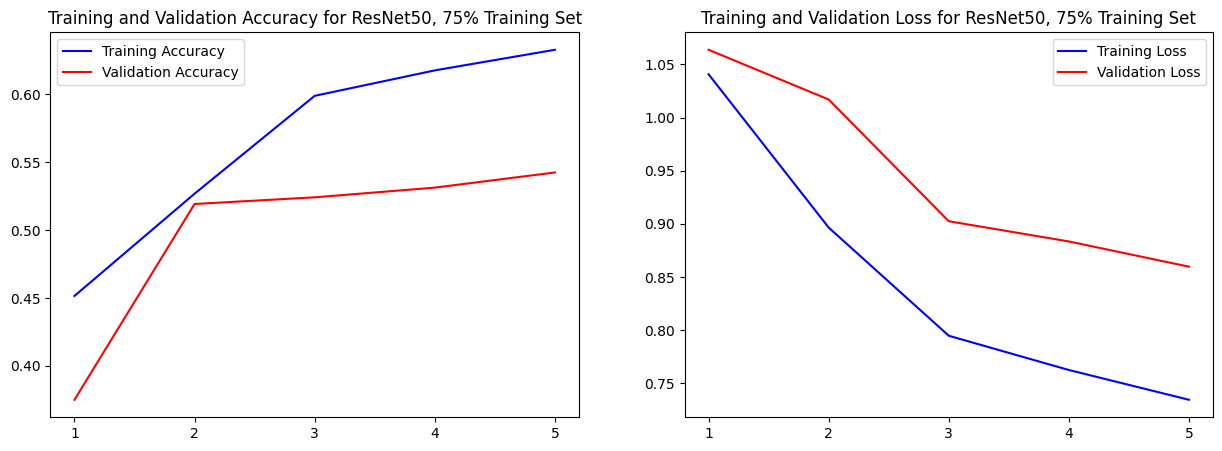

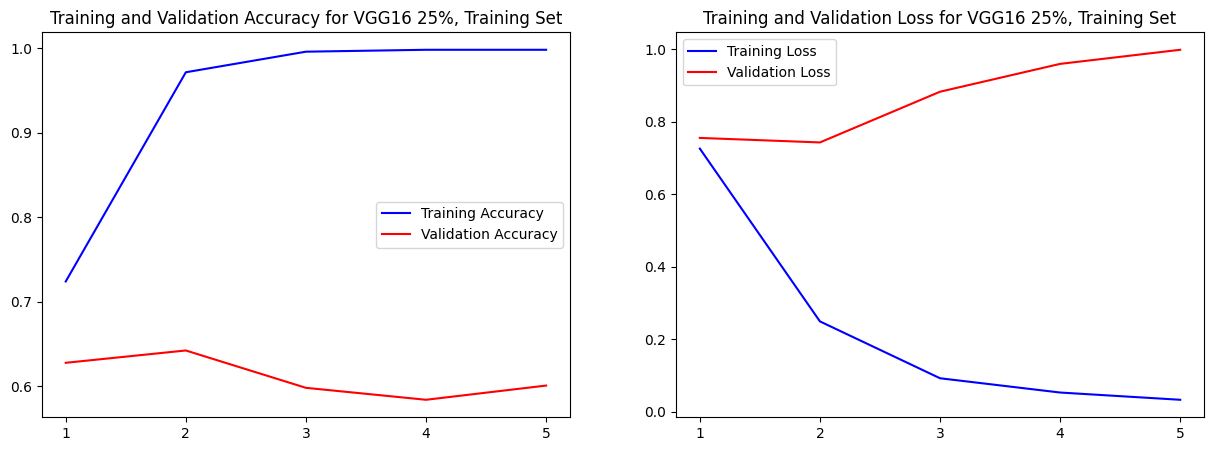

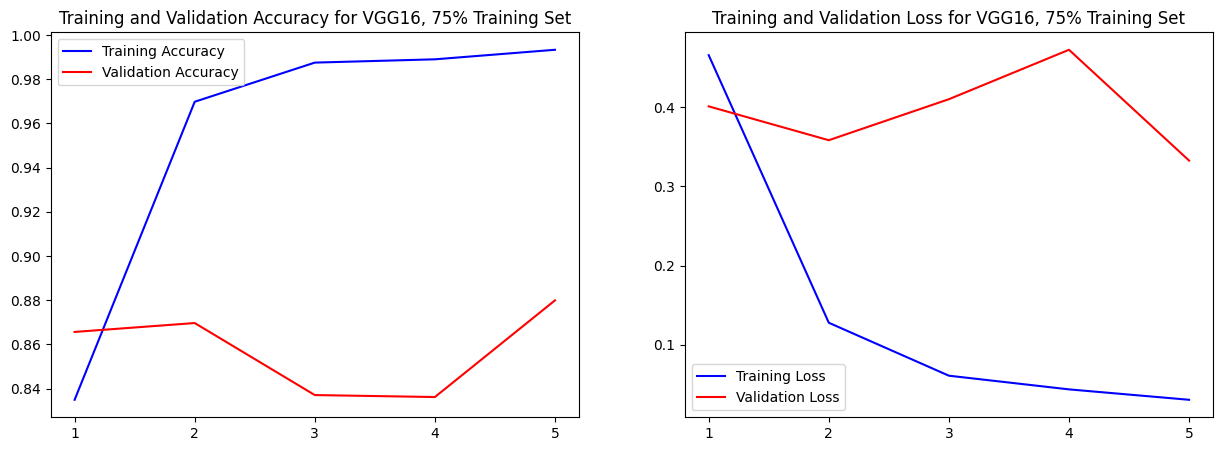

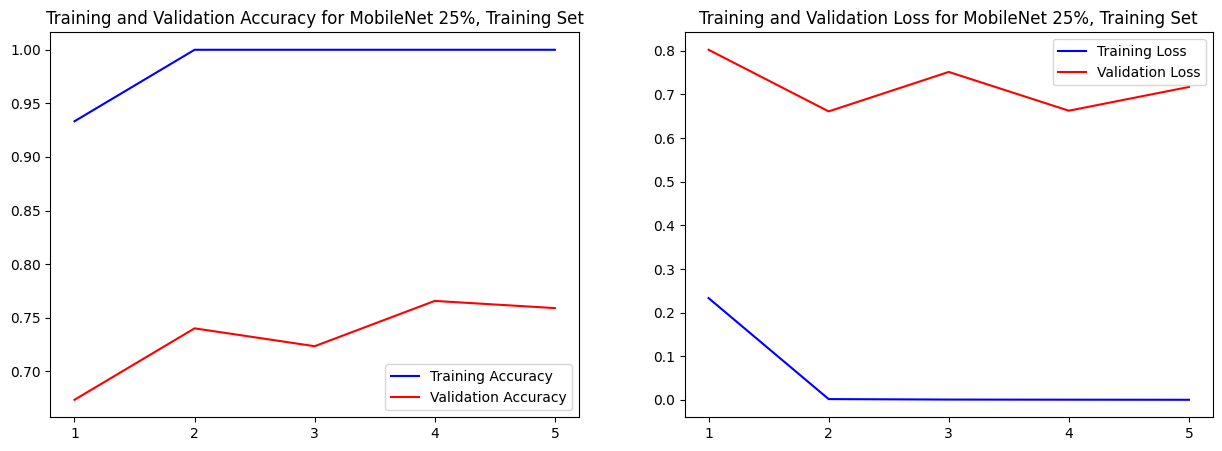

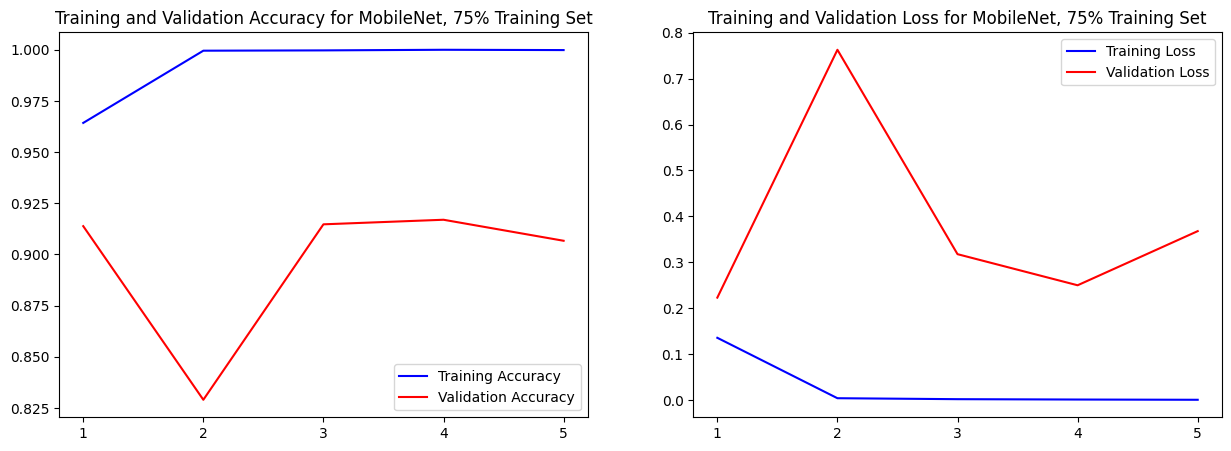

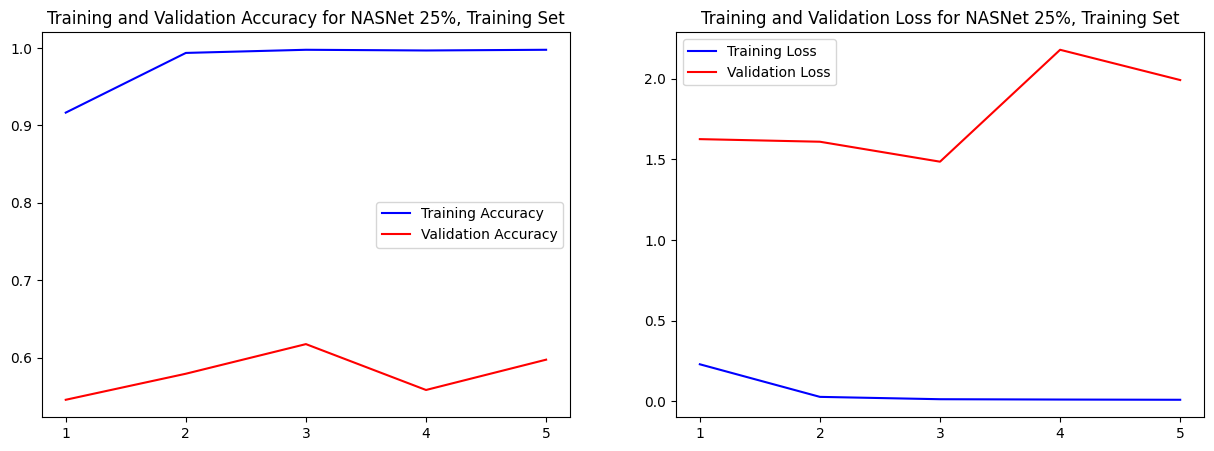

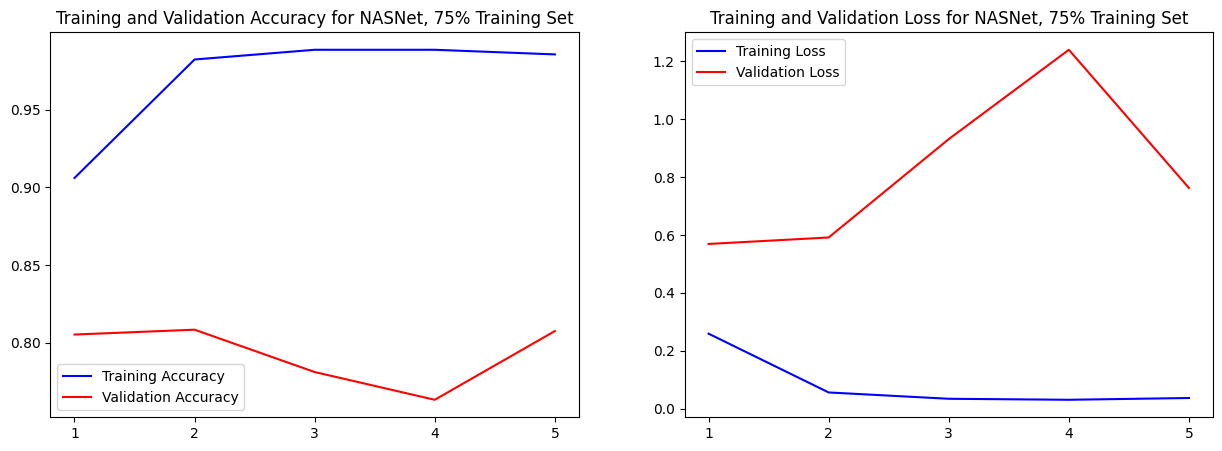

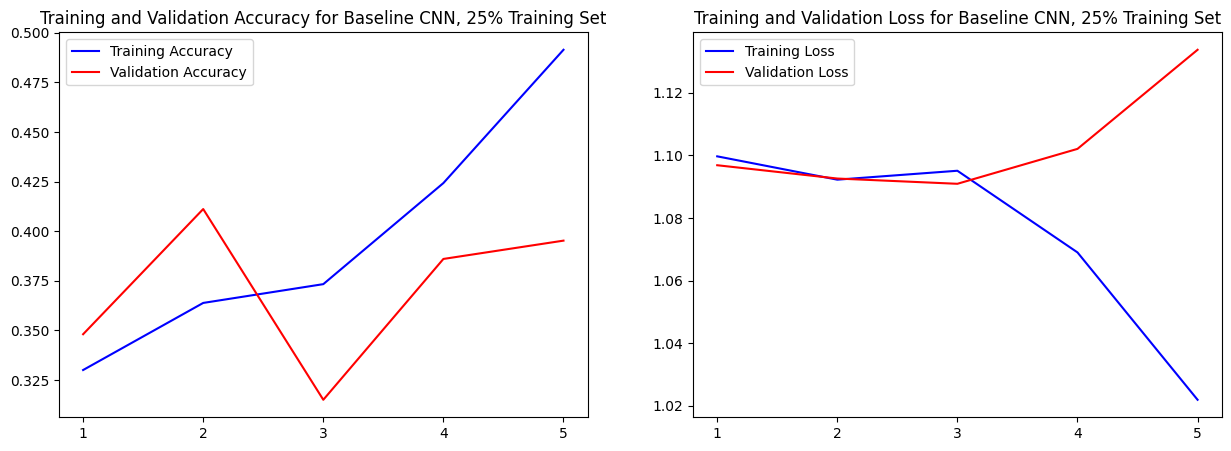

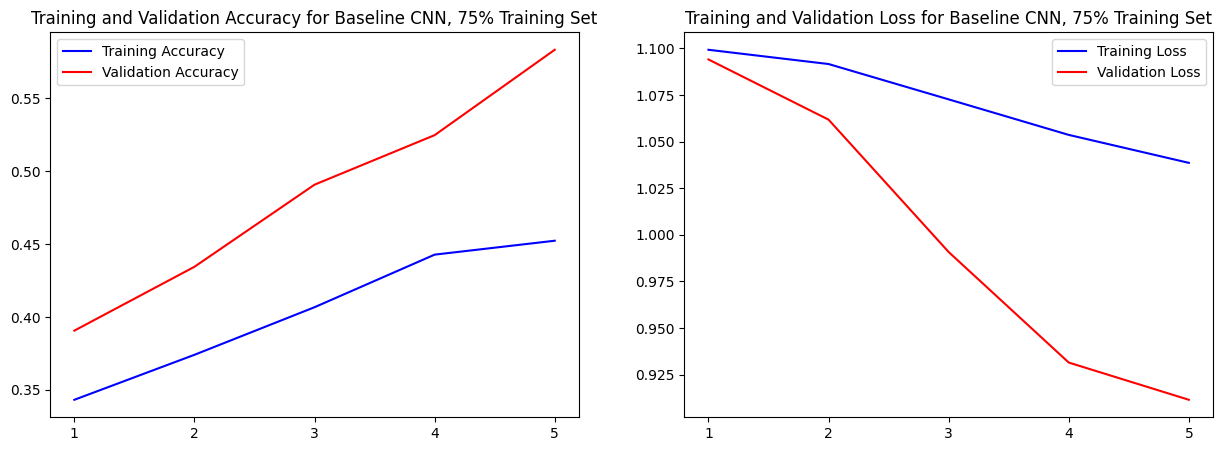

In [ ]:
# Plot Training Histories

plot_training_history(history_resnet25, 'ResNet50, 25% Training Set')
plot_training_history(history_resnet75, 'ResNet50, 75% Training Set')

plot_training_history(history_vgg25, 'VGG16 25%, Training Set')
plot_training_history(history_vgg75, 'VGG16, 75% Training Set')

plot_training_history(history_mobilenet25, 'MobileNet 25%, Training Set')
plot_training_history(history_mobilenet75, 'MobileNet, 75% Training Set')

plot_training_history(history_nasnet25, 'NASNet 25%, Training Set')
plot_training_history(history_nasnet75, 'NASNet, 75% Training Set')

plot_training_history(history_baseline25, 'Baseline CNN, 25% Training Set')
plot_training_history(history_baseline75, 'Baseline CNN, 75% Training Set')


In [ ]:
# Compare The Models - Function

# def compare_models(histories, titles, train_ratio, metric= 'accuracy'):
#   plt.figure(figsize= (8, 5))
#   for history, title in zip(histories, titles):
#     plt.plot(history[metric], label= f'{title} Train')
#     plt.plot(history[f'val_{metric}'], label= f'{title} Val')

#   plt.xlabel('Epochs')
#   plt.ylabel(metric.capitalize())
#   plt.title(f'Comparison of Models {metric.capitalize()}, {100 * train_ratio}% Training Set')

#   plt.legend()

#   plt.show()

def compare_models(histories, titles, train_ratio, metric= 'accuracy'):
  epochs = range(1, len(next(iter(histories))[metric]) + 1)

  #Training chart
  plt.figure(figsize= (8, 5))
  for history, title in zip(histories, titles):
    plt.plot(epochs, history[metric], label= f'{title} Train')

  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.title(f'Comparison of Models Training {metric.capitalize()}, {100 * train_ratio}% Training Set')
  plt.xticks(epochs)
  plt.legend()
  plt.show()

  #Validation chart
  plt.figure(figsize= (8, 5))
  for history, title in zip(histories, titles):
    plt.plot(epochs, history[f'val_{metric}'], label= f'{title} Val')

  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.title(f'Comparison of Models Validation {metric.capitalize()}, {100 * train_ratio}% Training Set')
  plt.xticks(epochs)
  plt.legend()
  plt.show()


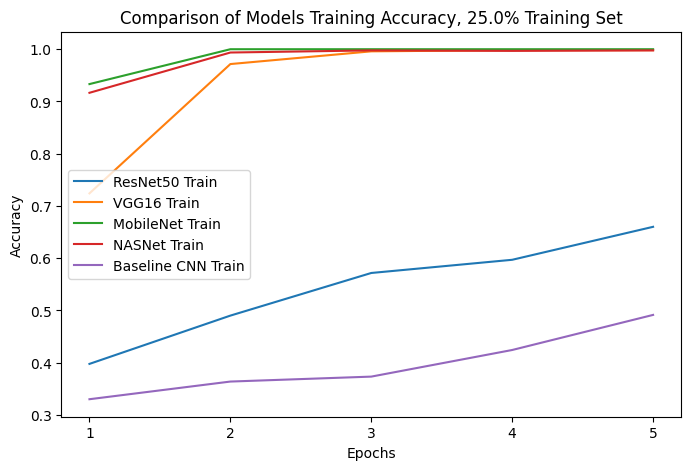

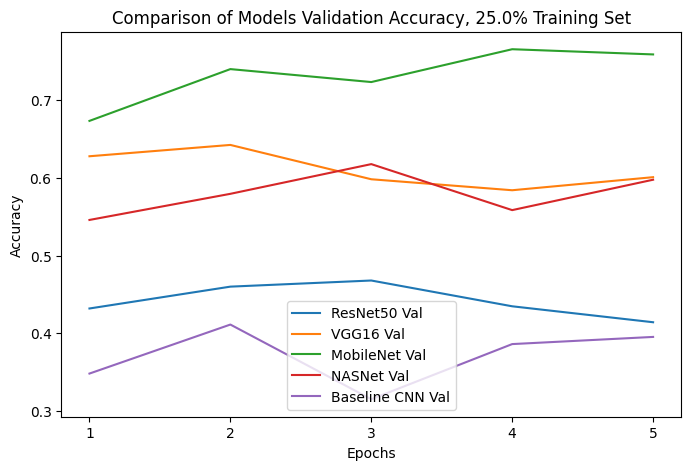

In [ ]:
# Compare The Models - 25% Training Set

models_to_compare = [history_resnet25, history_vgg25, history_mobilenet25, history_nasnet25, history_baseline25]
titles_to_compare = ['ResNet50', 'VGG16', 'MobileNet', 'NASNet', 'Baseline CNN']

compare_models(models_to_compare, titles_to_compare, 0.25)


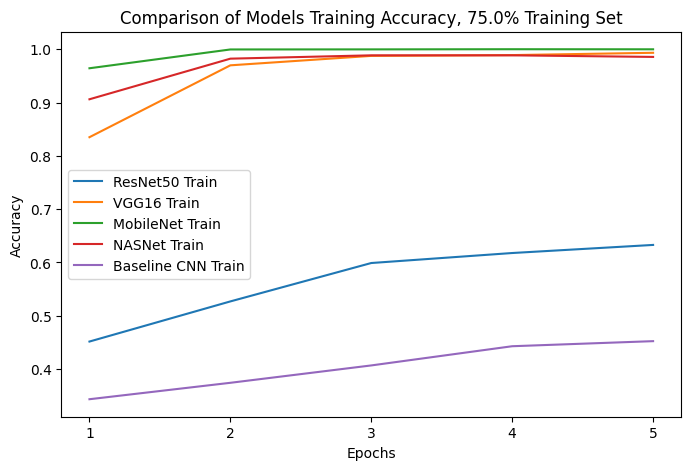

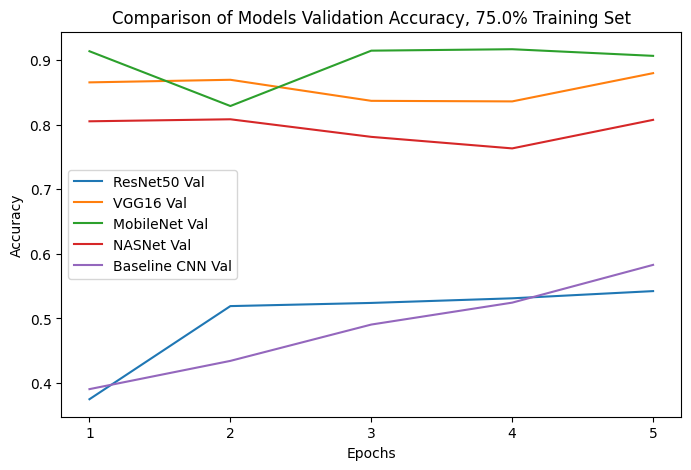

In [ ]:
# Compare The Models - 75% Training Set

models_to_compare = [history_resnet75, history_vgg75, history_mobilenet75, history_nasnet75, history_baseline75]
titles_to_compare = ['ResNet50', 'VGG16', 'MobileNet', 'NASNet', 'Baseline CNN']

compare_models(models_to_compare, titles_to_compare, 0.75)


**Predictions on New Images**

In [ ]:
def preprocess_input_baseline(x):
  return x * (1./255)

In [37]:
# Load and Process New Images for (244, 244) Input Size

def load_images_from_folder244(folder, model_name):
  images = []
  filenames = []
  actual_labels = []
  for class_name in os.listdir(folder):
    class_path = os.path.join(folder, class_name)
    if os.path.isdir(class_path):
      for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        if img_path.endswith('.jpg') or img_path.endswith('.png'):
          img = load_img(img_path, target_size= (224, 224))
          img_array = img_to_array(img)
          img_array = np.expand_dims(img_array, axis= 0)

          if model_name == 'ResNet50':
            img_array = preprocess_input_resnet(img_array)
          elif model_name == 'VGG16':
            img_array = preprocess_input_vgg(img_array)
          elif model_name == 'MobileNet':
            img_array = preprocess_input_mobilenet(img_array)
          elif model_name == 'NASNet':
            img_array = preprocess_input_nasnet(img_array)
          elif model_name == 'Baseline CNN':
            img_array = preprocess_input_baseline(img_array)

          images.append(img_array)
          filenames.append(filename)
          actual_labels.append(class_name)

  return np.vstack(images), filenames, actual_labels


In [107]:
# Make Prediction - Models to Test and New Images Folder

models = {'resnet': resnet_model, 'vgg': vgg_model, 'mobilenet': mobilenet_model, 'nasnet': nasnet_model}

folder_path = 'Final/Test/'
#Update above path with correct folder


In [ ]:
# Make Prediction - Models to Test and New Images Folder, 75%/25% Training Split

models75 = {'ResNet50': resnet_model75, 'VGG16': vgg_model75, 'MobileNet': mobilenet_model75, 'NASNet': nasnet_model75, 'Baseline CNN': baseline_model75}

models25 = {'ResNet50': resnet_model25, 'VGG16': vgg_model25, 'MobileNet': mobilenet_model25, 'NASNet': nasnet_model25, 'Baseline CNN': baseline_model25}

folder_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/Prediction'


In [ ]:
# Make Prediction - Generator

datagen = ImageDataGenerator(rescale = 1. / 255)

pred_generator = datagen.flow_from_directory(
    folder_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)


In [89]:
# Make Prediction - Function

def make_predictions(models, folder_path, class_indices):

  predictions = {}

  for model_name, model in models.items():
    images, filenames, actual_labels = load_images_from_folder244(folder_path, model_name)
    preds = model.predict(images)

    actual_indices = [class_indices[label] for label in actual_labels]

    predictions[model_name] = (preds, filenames, actual_labels, actual_indices)


    predictions[model_name] = (preds, filenames, actual_labels, actual_indices)

  return predictions


In [90]:
# Make Prediction - Result Function

def plot_images_with_pred(folder_path, model_predictions, class_indices):

  index_to_class = {v: k for k, v in class_indices.items()}

  for model_name, (preds, filenames, actual_labels, actual_indices) in model_predictions.items():
    for i, filename in enumerate(filenames):
      img_path = os.path.join(folder_path, actual_labels[i], filename)
      img = plt.imread(img_path)
      predicted_class_index = np.argmax(preds[i])
      predicted_class_name = index_to_class[predicted_class_index]

      plt.figure(figsize= (5, 5))
      plt.imshow(img)
      plt.title(f'Model: {model_name}\nPredicted: {predicted_class_name}\nActual: {actual_labels[i]}')
      plt.axis('off')
      plt.show()


In [ ]:
# Make Prediction

plot_images_with_pred(folder_path, nasnet_model75)


In [95]:
from keras.preprocessing import image
from keras.applications.nasnet import preprocess_input
import numpy as np

def load_and_preprocess_images(folder_path):
    # Assuming images are stored in the folder_path
    # and you want to load and preprocess them for NASNet

    # Get the list of image file names
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Load and preprocess each image
    images = []
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size based on your model requirements
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        images.append(img_array)

    return np.vstack(images)  # Stack the images into a single array


In [ ]:
import os

def make_predictions(model, folder_path):
    # Load and preprocess images from the folder (you need to implement this function)
    images = load_and_preprocess_images(folder_path)

    # Make predictions using the model
    predictions = model.predict(images)

    # Assuming you have actual labels for comparison
    actual_labels = get_actual_labels(folder_path)

    return predictions, actual_labels

# Example usage
#nasnet_model75 = load_model("nasnet75_model.h5")  # Load your NASNet model
folder_path = 'Test'
model_predictions, actual_labels = make_predictions(nasnet_model75, folder_path)

# Example of printing the predictions
print(model_predictions)


In [105]:
import os

def get_actual_labels(folder_path):
    # Get the list of subfolder names (class labels)
    labels = [label for label in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, label)) and not label.startswith('.')]

    # If subfolders are empty, go one level deeper
    if not labels:
        subfolder_path = os.path.join(folder_path, os.listdir(folder_path)[0])
        labels = [subfolder for subfolder in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, subfolder)) and not subfolder.startswith('.')]

    return labels

# Example usage
actual_labels = get_actual_labels(folder_path)
print(actual_labels)


['i']


In [ ]:
import os

def get_actual_labels(folder_path):
    # Get the list of subfolder names (class labels)
    labels = [label for label in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, label))]

    # If subfolders are empty or if there are non-directory files in the folder, go one level deeper
    if not labels:
        subfolder_path = os.path.join(folder_path, os.listdir(folder_path)[0])

        # Check if subfolder_path is a file or symlink; if so, go one level deeper
        if os.path.isfile(subfolder_path) or os.path.islink(subfolder_path):
            subfolder_path = os.path.join(folder_path, os.path.dirname(subfolder_path))

        labels = [subfolder for subfolder in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, subfolder))]

    return labels

# Example usage
actual_labels = get_actual_labels(folder_path)
print(actual_labels)


In [ ]:
# Model Evaluation Plot - Function

def plot_model_evaluations(evaluation_results, class_indices):
  n_models = len(evaluation_results)
  plt.figure(figsize = (15, 5 * n_models))

  for i, (model_name, results) in enumerate(evaluation_results.items(), 1):
    plt.subplot(n_models, 2, 2 * i - 1)
    sns.heatmap(results['confusion_matrix'], annot = True, fmt = 'd', cmap = 'Blues',
                xticklabels = class_indices.keys(), yticklabels = class_indices.keys())
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(n_models, 2, 2 * i)
    plt.bar(['Accuracy'], [results['accuracy']])
    plt.title(f'{model_name} - Accuracy')
    plt.ylim(0, 1)

  plt.tight_layout()
  plt.show()


In [ ]:
# Model Evaluation - Function

def evaluate_models(model_predictions):

  evaluation_results = {}

  for model_name, (preds, filenames, actual_labels, actual_indices) in model_predictions.items():
    predicted_indices = np.argmax(preds, axis = 1)

    conf_matrix = confusion_matrix(actual_indices, predicted_indices)
    accuracy = accuracy_score(actual_indices, predicted_indices)

    evaluation_results[model_name] = {'confusion_matrix': conf_matrix, 'accuracy': accuracy}

  return evaluation_results


1/1 [==============================] - 0s 80ms/step


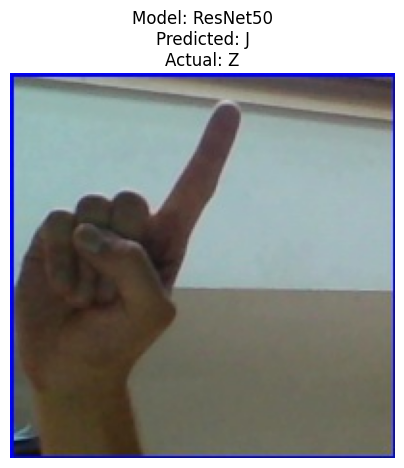

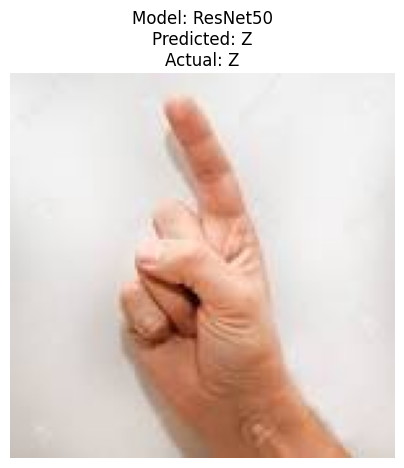

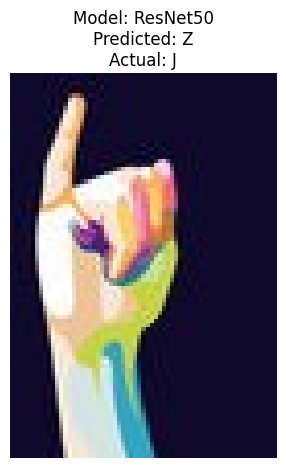

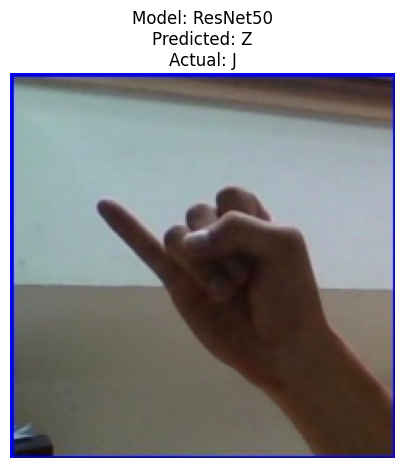

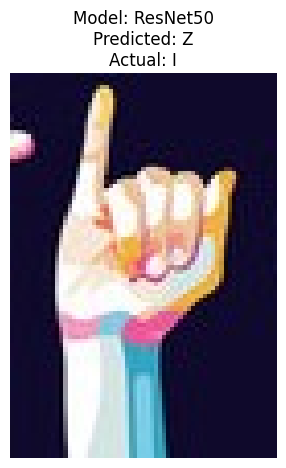

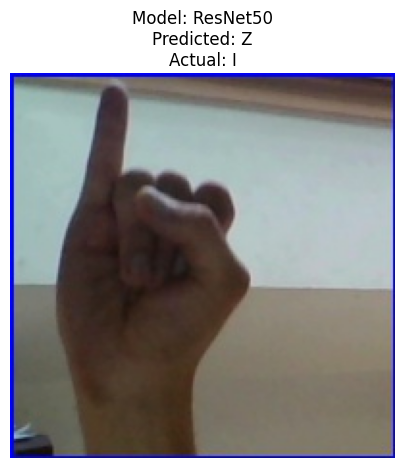

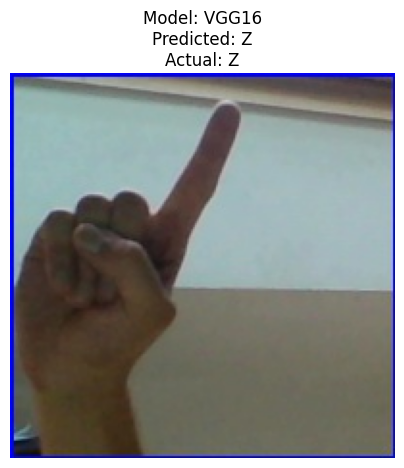

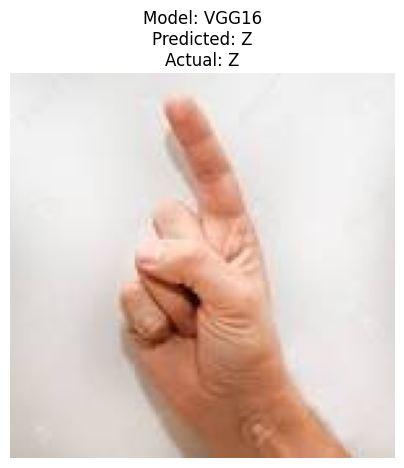

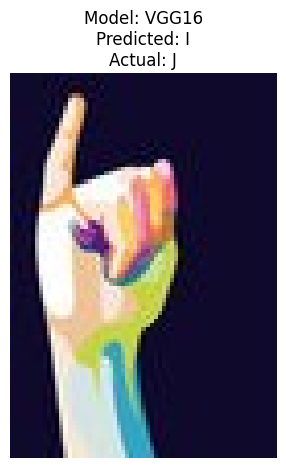

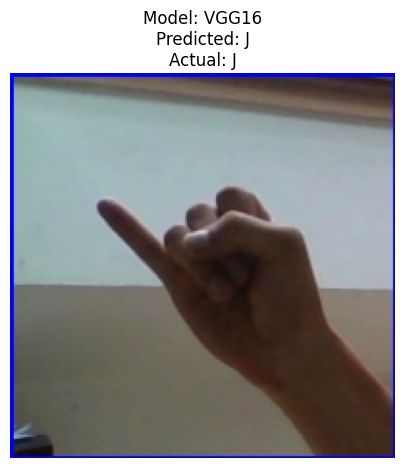

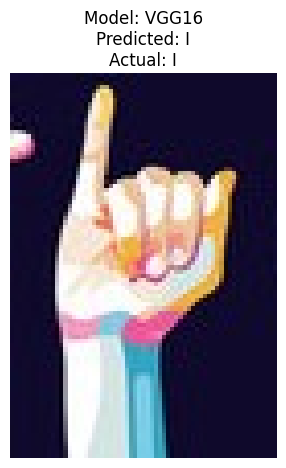

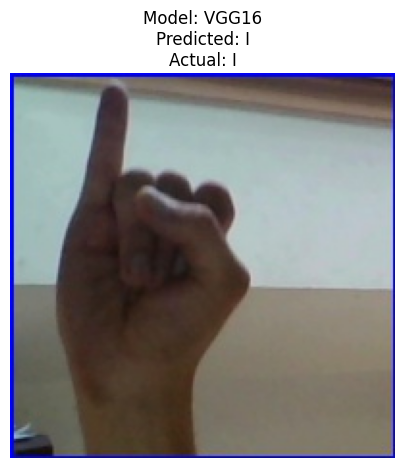

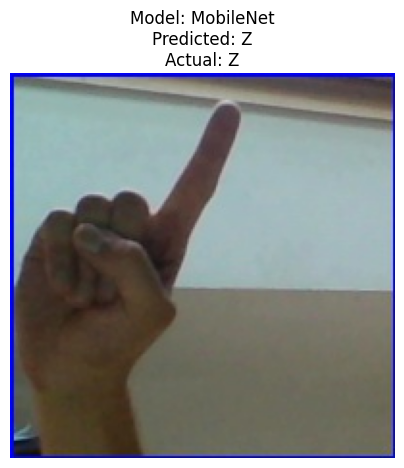

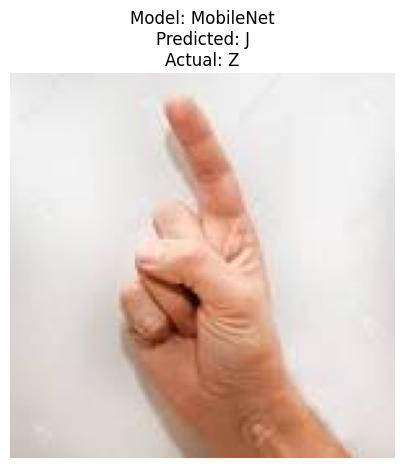

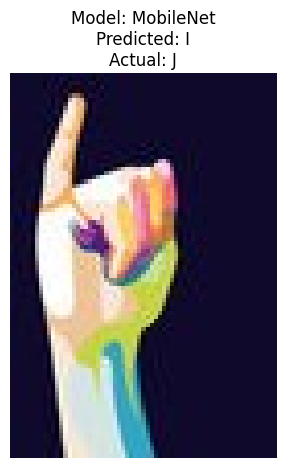

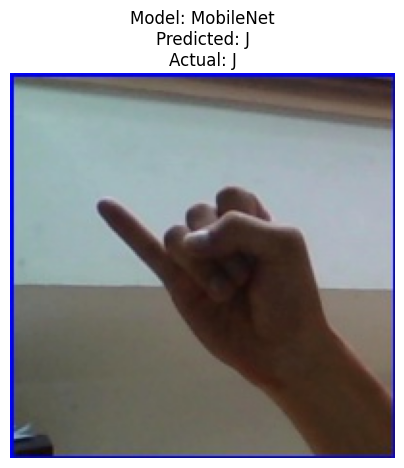

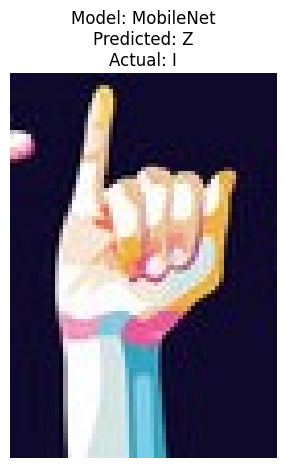

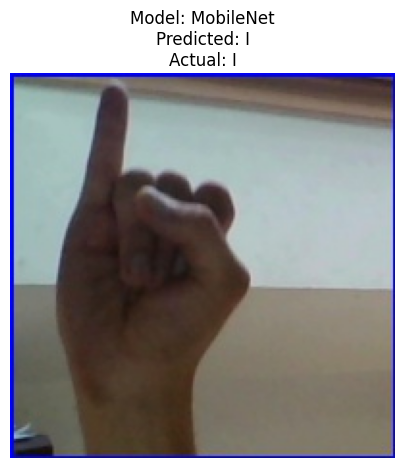

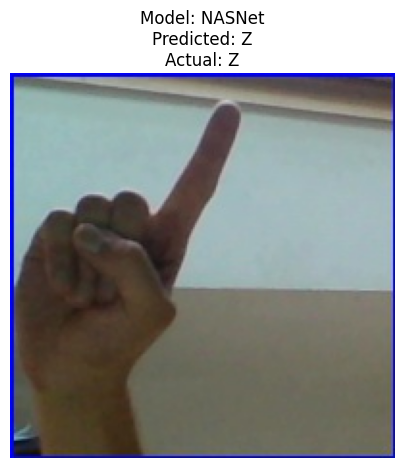

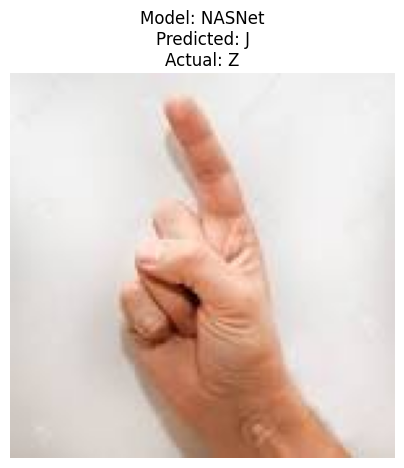

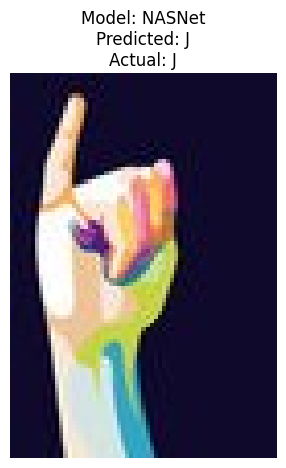

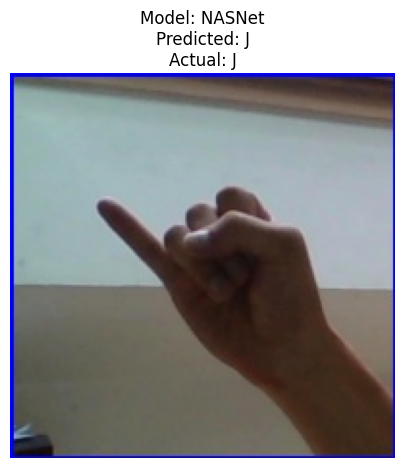

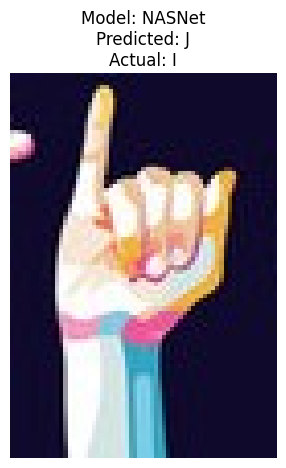

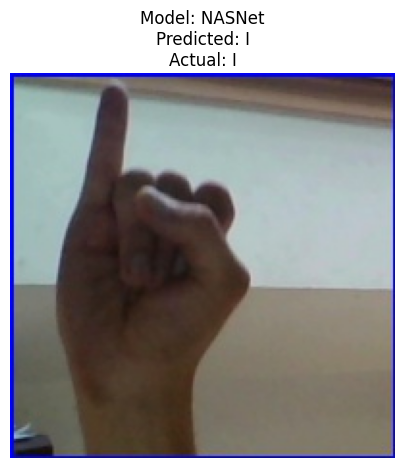

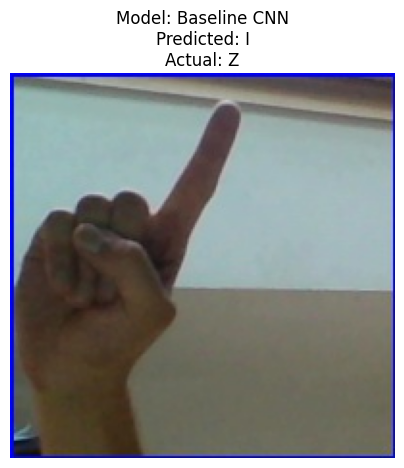

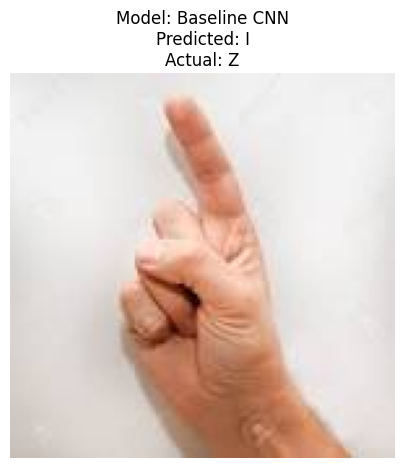

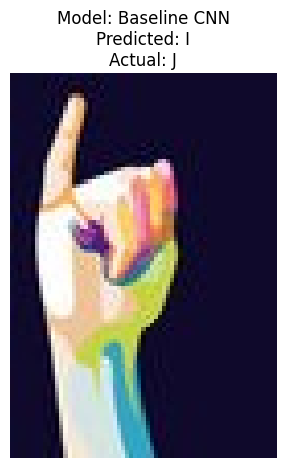

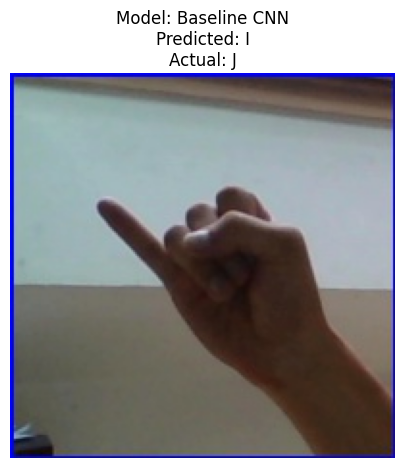

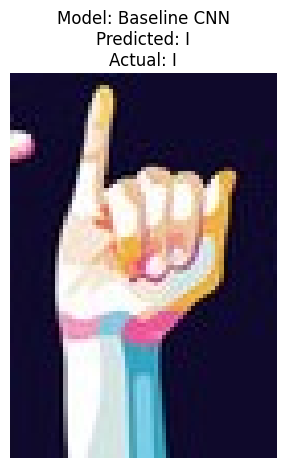

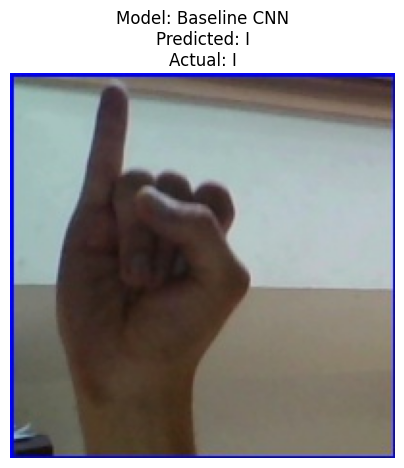

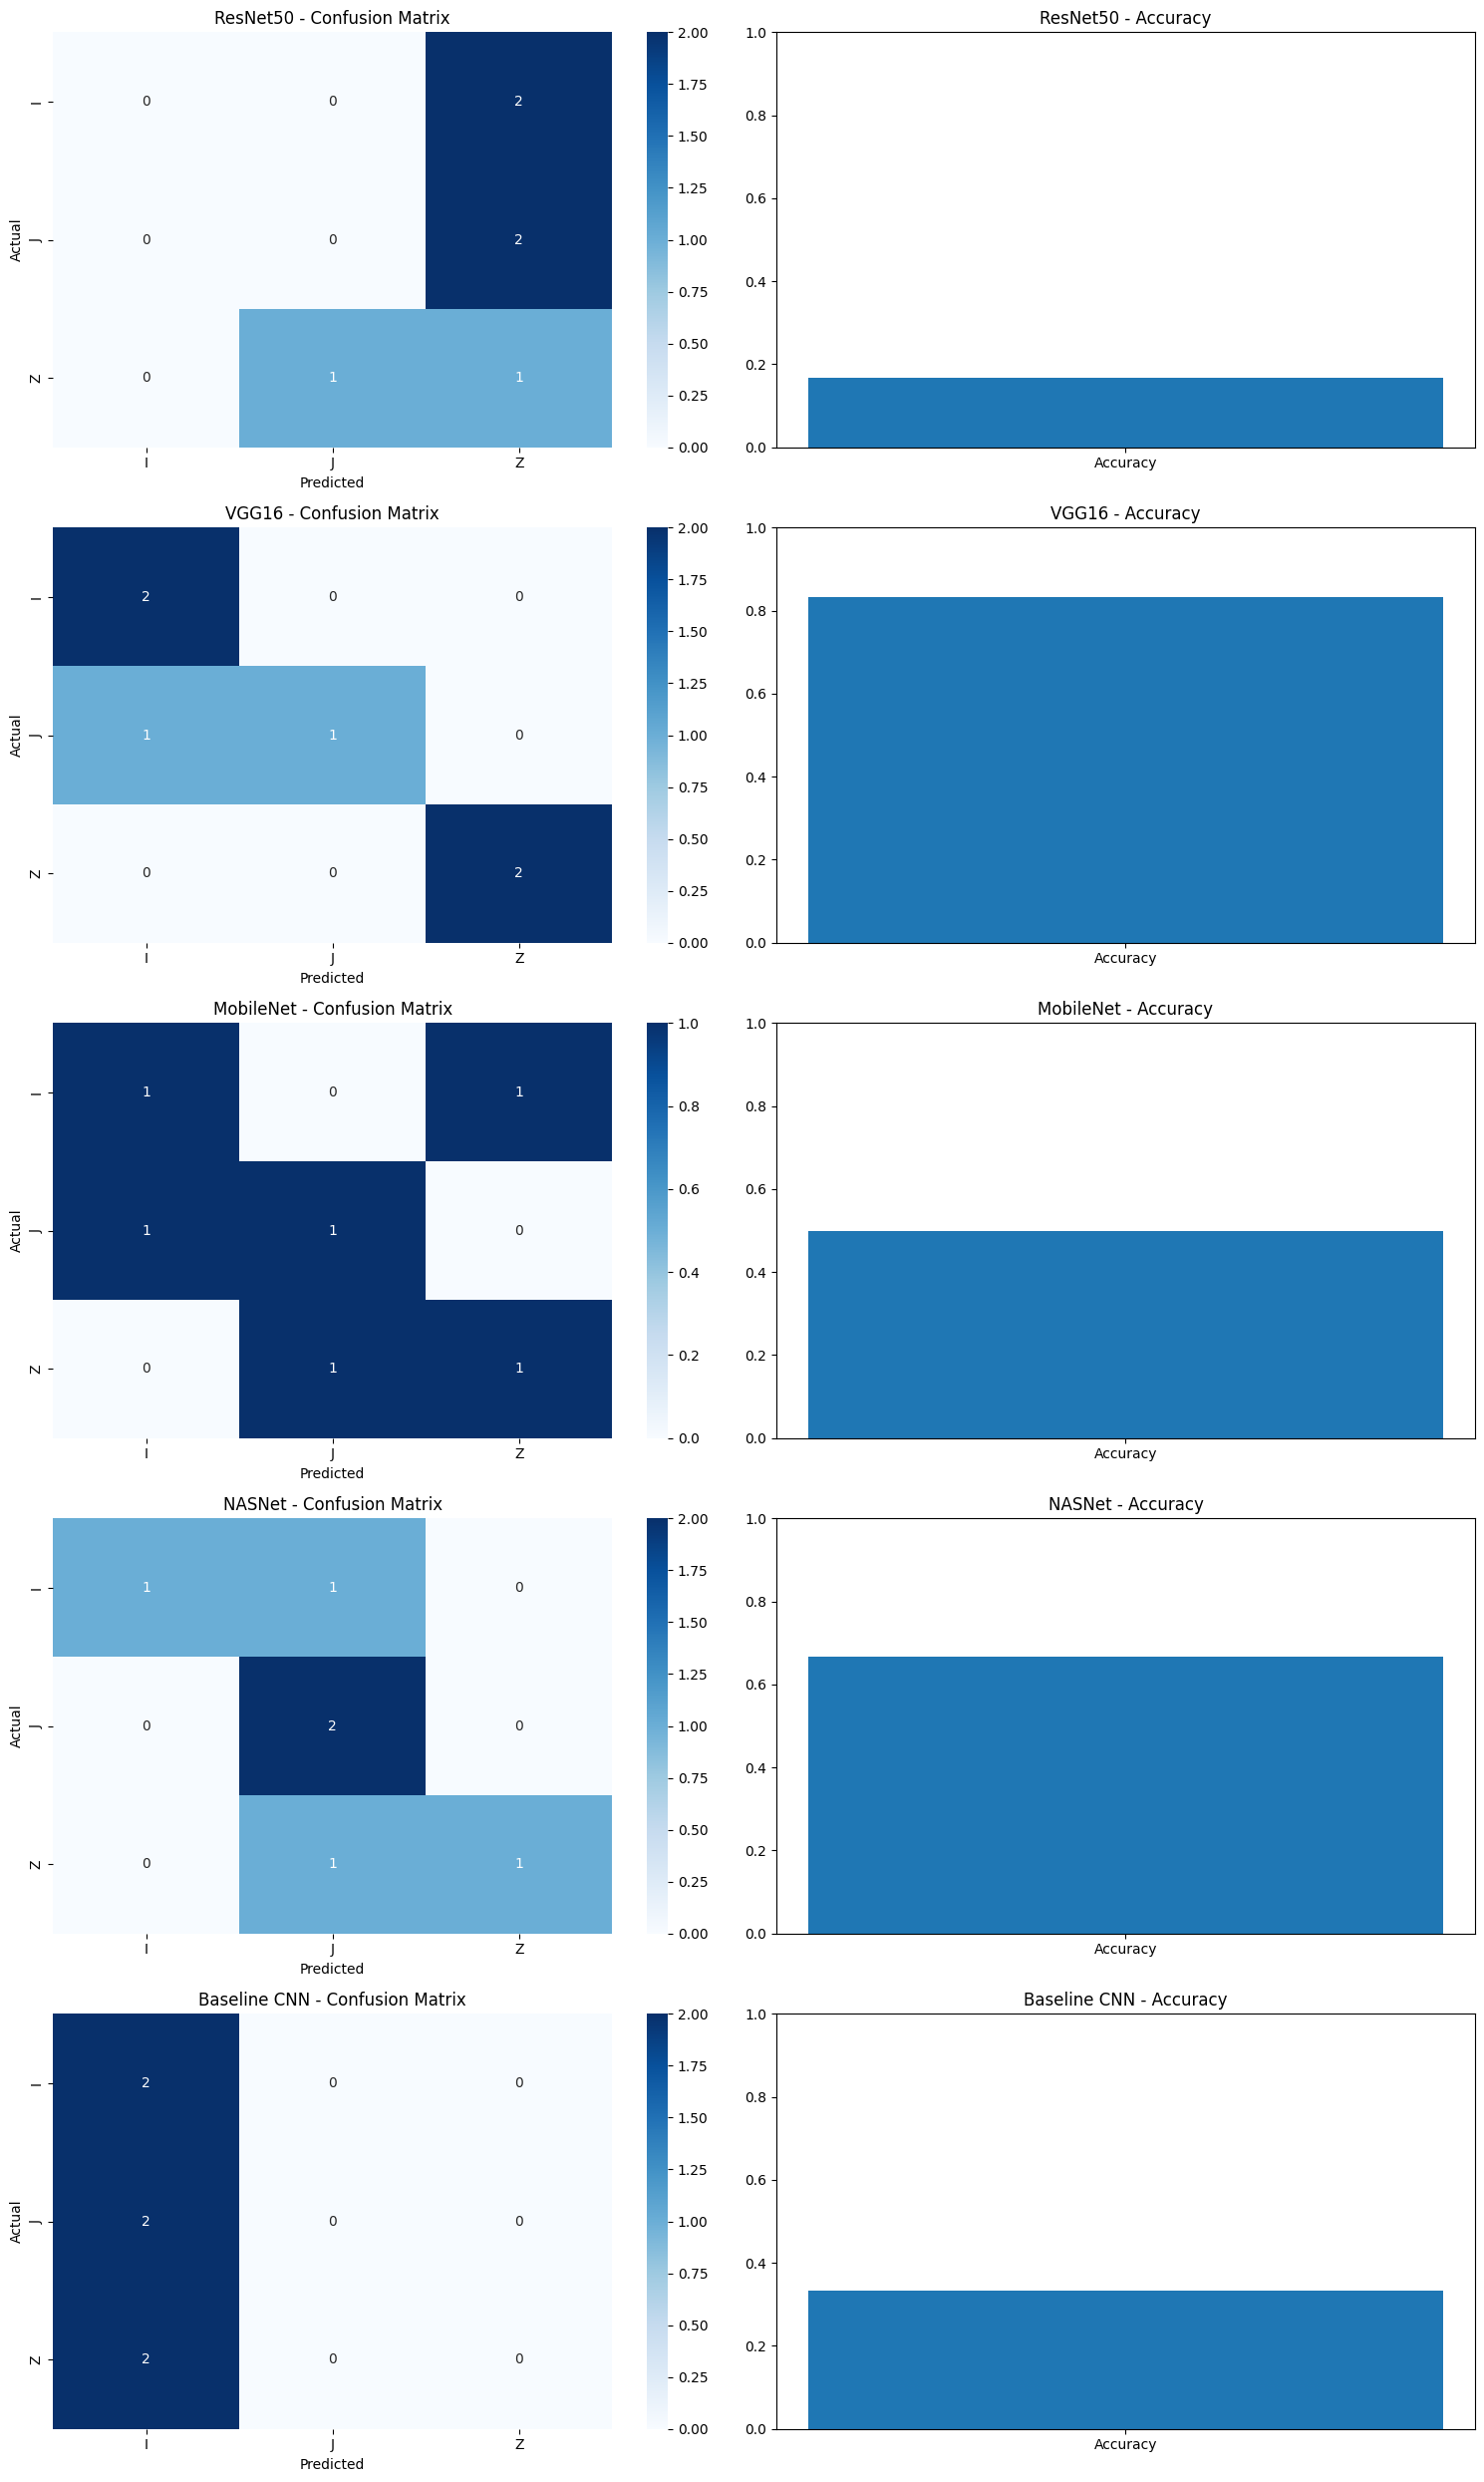

In [ ]:
# Make Prediction and Plot

class_indices = pred_generator.class_indices

model_predictions = make_predictions(models75, folder_path, class_indices)

evaluation_results = evaluate_models(model_predictions)

plot_images_with_pred(folder_path, model_predictions, pred_generator.class_indices)

plot_model_evaluations(evaluation_results, class_indices)


**Unused/Legacy Code Below**

In [ ]:
# *************************
# UNSUSED/LEGACY CODE BELOW
# *************************

In [ ]:
# Define models

# resnet_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

# resnet_model.trainable = False

# res_x = resnet_model.output
# res_x = GlobalAveragePooling2D()(res_x)
# res_x = Dense(1024, activation = 'relu')(res_x)
# res_predictions = Dense(train_generator.num_classes, activation = 'softmax')(res_x)
# res_model = Model(inputs = resnet_model.input, outputs = res_predictions)

# res_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# res_history = res_model.fit(
#     train_generator,
#     steps_per_epoch = train_generator.samples // train_generator.batch_size,
#     validation_data = validation_generator,
#     validation_steps = validation_generator.samples // validation_generator.batch_size,
#     epochs = 5
# )


Epoch 1/5
2175/2175 [==============================] - 1191s 548ms/step - loss: 2.5084 - accuracy: 0.2486 - val_loss: 2.7437 - val_accuracy: 0.1831
Epoch 2/5
2175/2175 [==============================] - 1156s 532ms/step - loss: 2.3184 - accuracy: 0.2979 - val_loss: 2.6836 - val_accuracy: 0.2044
Epoch 3/5
2175/2175 [==============================] - 1110s 510ms/step - loss: 2.2007 - accuracy: 0.3305 - val_loss: 2.6327 - val_accuracy: 0.2089
Epoch 4/5
2175/2175 [==============================] - ETA: 0s - loss: 2.1017 - accuracy: 0.3598

In [ ]:
# res_model.save('asl_resnet50.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# eval_result = res_model.evaluate(validation_generator)
# print('Validation Loss: ', eval_result[0])
# print('Validation Accuracy: ', eval_result[1])

544/544 [==============================] - 230s 422ms/step - loss: 2.9410 - accuracy: 0.1383
Validation Loss:  2.941020965576172
Validation Accuracy:  0.13833333551883698


In [ ]:
# ResNet50 model/history - Save

# model_save_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/asl_resnet50.h5'

# resnet_model.save(model_save_path)

# history_dict_resnet = history_resnet.history

# history_save_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/asl_resnet50_history.json'

# with open(history_save_path, 'w') as file:
#   json.dump(history_dict_resnet, file)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# VGG16 model/history - Save

# model_save_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/asl_vgg16.h5'

# vgg_model.save(model_save_path)

# history_dict_vgg = history_vgg.history

# history_save_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/asl_vgg16_history.json'

# with open(history_save_path, 'w') as file:
#   json.dump(history_dict_vgg, file)


In [ ]:
# MobileNet model/history - Save

# model_save_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/asl_mobilenet.h5'

# mobilenet_model.save(model_save_path)

# history_dict_mobilenet = history_mobilenet.history

# history_save_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/asl_mobilenet_history.json'

# with open(history_save_path, 'w') as file:
#   json.dump(history_dict_mobilenet, file)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# NASNet model/history - Save

# model_save_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/asl_nasnet.h5'

# nasnet_model.save(model_save_path)

# history_dict_nasnet = history_nasnet.history

# history_save_path = '/content/drive/My Drive/H518_DeepLearningNN/Final_Project/asl_nasnet_history.json'

# with open(history_save_path, 'w') as file:
#   json.dump(history_dict_nasnet, file)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# with open(history_load_path_resnet, 'r') as file:
#   history_resnet = json.load(file)

# with open(history_load_path_vgg, 'r') as file:
#   history_vgg = json.load(file)

# with open(history_load_path_mobilenet, 'r') as file:
#   history_mobilenet = json.load(file)

# with open(history_load_path_nasnet, 'r') as file:
#   history_nasnet = json.load(file)
